# Hypothesis Testing - Sharpe

- ( https://www.investopedia.com/ask/answers/010815/what-good-sharpe-ratio.asp )
- ( http://web.stanford.edu/~wfsharpe/art/sr/SR.htm )
- ( http://127.0.0.1:8888/?token=594f9ee94e6a4e06ce512313e7c6eabca5469117e2673c79 )
- ( https://github.com/braverock/PerformanceAnalytics/issues/142 )


Statistics in historical_stats_modern are calculated WEEKLY on Collective2.

Let's see C2 Sharpe data globaly. 

In [85]:
source("JupyterUtils.R")
# library(IRdisplay)

In [6]:
dbData = getC2ScoreDbData("select systemid, YYYYMMDD, statval from historical_stats_modern where statname='jSharpe'")
NUMBER_OF_SYSTEMS = length(unique(dbData$systemid))

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD        NA's 
         7079      235487  -3037.5700     -0.8000      0.4800    -0.09512      1.4100    639.2100     16.3946        2227 


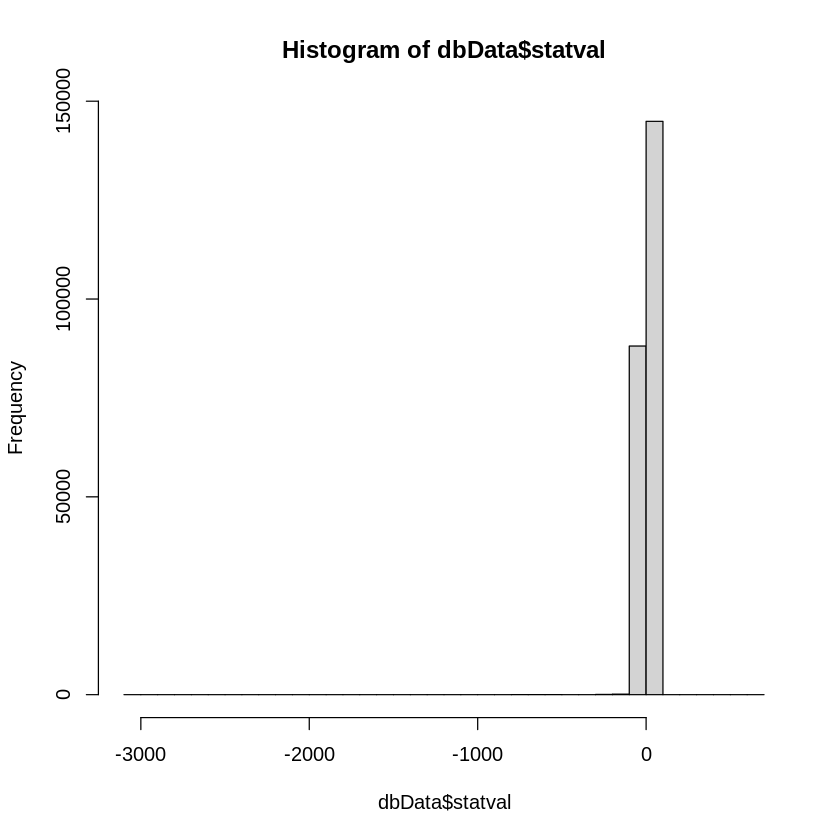

In [46]:
overview(dbData)
hist(dbData$statval,breaks=50)

In [1]:
# Statistic data does not look quite right. Too wide range, a mean far away from a median, null values, probably outliers too. 
# Let's try to clean this data. Say, that Sharpe should be between -5 and 5 and NULLs are errors. Get them:
sql = "select count(distinct(systemid)) as Systems from historical_stats_modern 
        where statname='jSharpe' and (statval is null or statval < -5 or statval > 5)"
bad_vals_systems = getC2ScoreDbData(sql)$Systems
cat("\nSystems with bad values:",bad_vals_systems,".\nIt is",round(100 * bad_vals_systems/NUMBER_OF_SYSTEMS,0),"% of all systems.\n")

ERROR: Error in dbConnect(MySQL(), user = "root", password = Sys.getenv("MySqlLocalPassword"), : could not find function "dbConnect"


It is 3/4/2021 today. The above percent is 90% today. 

It must be some systematic error in calculations. It should be fixed in the future.

However, we have this percent today and we need to cope with it somehow.
For now, the systematic error means it is not a problem of some failed systems and we can't remove such systems completely from our data.

We must suppose the systems are OK and we just remove Sharpe outliers from observations.

But how? Let's try it.

Sharpe can be any number from negative infinite to positive infinite.

It is a ratio (Return - RiskFreeReturn) / Std(Return)

- Those numbers are annualy. This is the first problem: annualy means more than 1 year.
Well, we are trying to apply Sharpe on daily or weekly data.

- The standard return in the denominator is a random variable which has chi probability distribution. It jumps wildly if a number of observations is low. Using this denominator leads to wild jums in Sharpe which we can see in 90% of trading systems.
So if we want to use Sharpe, it must be always with sufficient number of observations. Probably 40-60 observations.
It means 2-3 months if we have a daily data. (Right now, I am not sure if it also means ~1 year if we have a weekly data.)

- The RiskFreeReturn in the Sharpe formula should be about 3%. Well, it clearly means that Sharpe is constructed for a very different world than Collective2 represents. Usage of 3% makes sense if Annual Return is somewhere around 15%. But if we, at Collective2 are interested in returns about 50%? Does it make a difference if it is 47% or 53% ? No. We can safely use RiskFreeReturn = 0 and nothing wrong happens.

So the question is: Is Sharpe applicable on Collective2 at all? Sure, it is, if the system age is ~3 years. But how many of such systems exist in the Collective2 database?

OK. Lets suppose we really wanht to use it. We see we have starnge values in the database. We should clean them.

We are interesting only in positive values. 

Let's get some specific value: Sharpe = 5.
What does it mean? For example, 50% annual return divided by 10% annual volatility. Does it sound like numbers from the real world? Probably not. We do know that Sharpe = 1 is considered very good and Sharpe = 2 is excellent. 

Sharpe = 2 means 50% return and 25% SD. 

Or, if we chose some reasonable volatility in denominator, say 35% than the nominator (annual return) must be 70%. 

I think we can conclude that any Sharpe value greater than 2 in our database is either a strategy outlier or error in calculations.

Summary: If we want to use Sharpe, it must be in the range  [0; 2] and Age > 60 days. 

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
         1550       34382      0.0100      0.5100      0.9100      0.9391      1.3475      2.0000      0.5251 


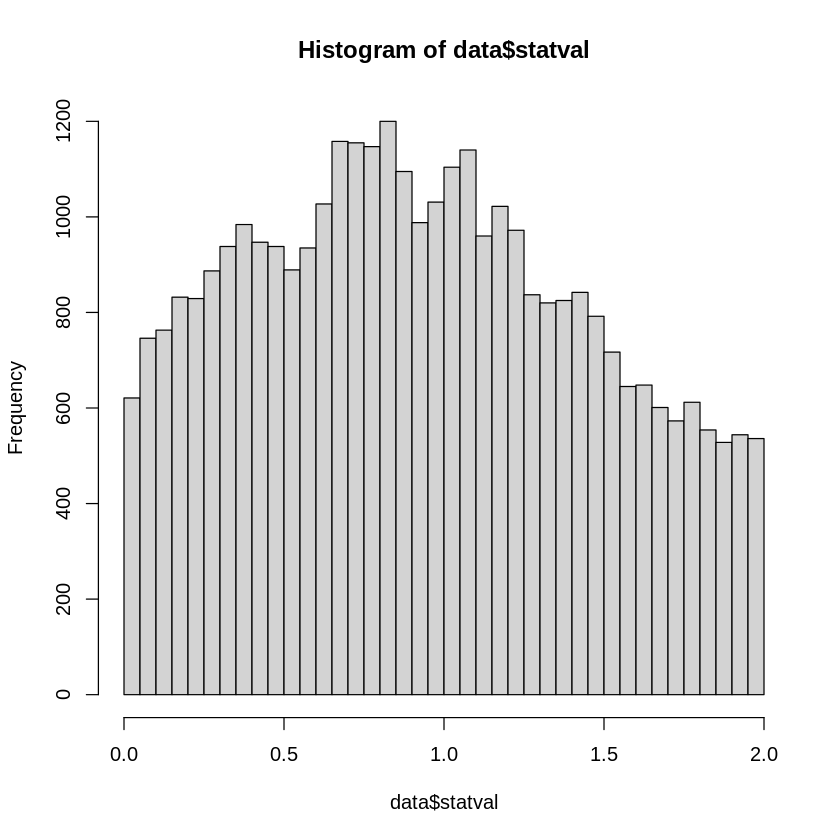

In [47]:
sql = "select statval, eq.*
 from ReturnsDataInIntervalsCleaned eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where 
    statname='jSharpe' 
    and statval > 0 
    and statval <= 2 
    and Age > 60"

data = getC2ScoreDbData(sql)
overview(data)
hist(data$statval,breaks=50)

In [88]:
source("C2ScoreHypthesisPresentation.R")
options(repr.plot.width=12, repr.plot.height=8)

In [49]:
#populationStatsData = getPopulationStatsData()

Description of data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1550       34382      0.0100      0.5100      0.9100      0.9391      1.3475      2.0000      0.5251 

Attribute steps:
0 0.25 0.5 0.75 1 1.25 1.5 1.75 2 



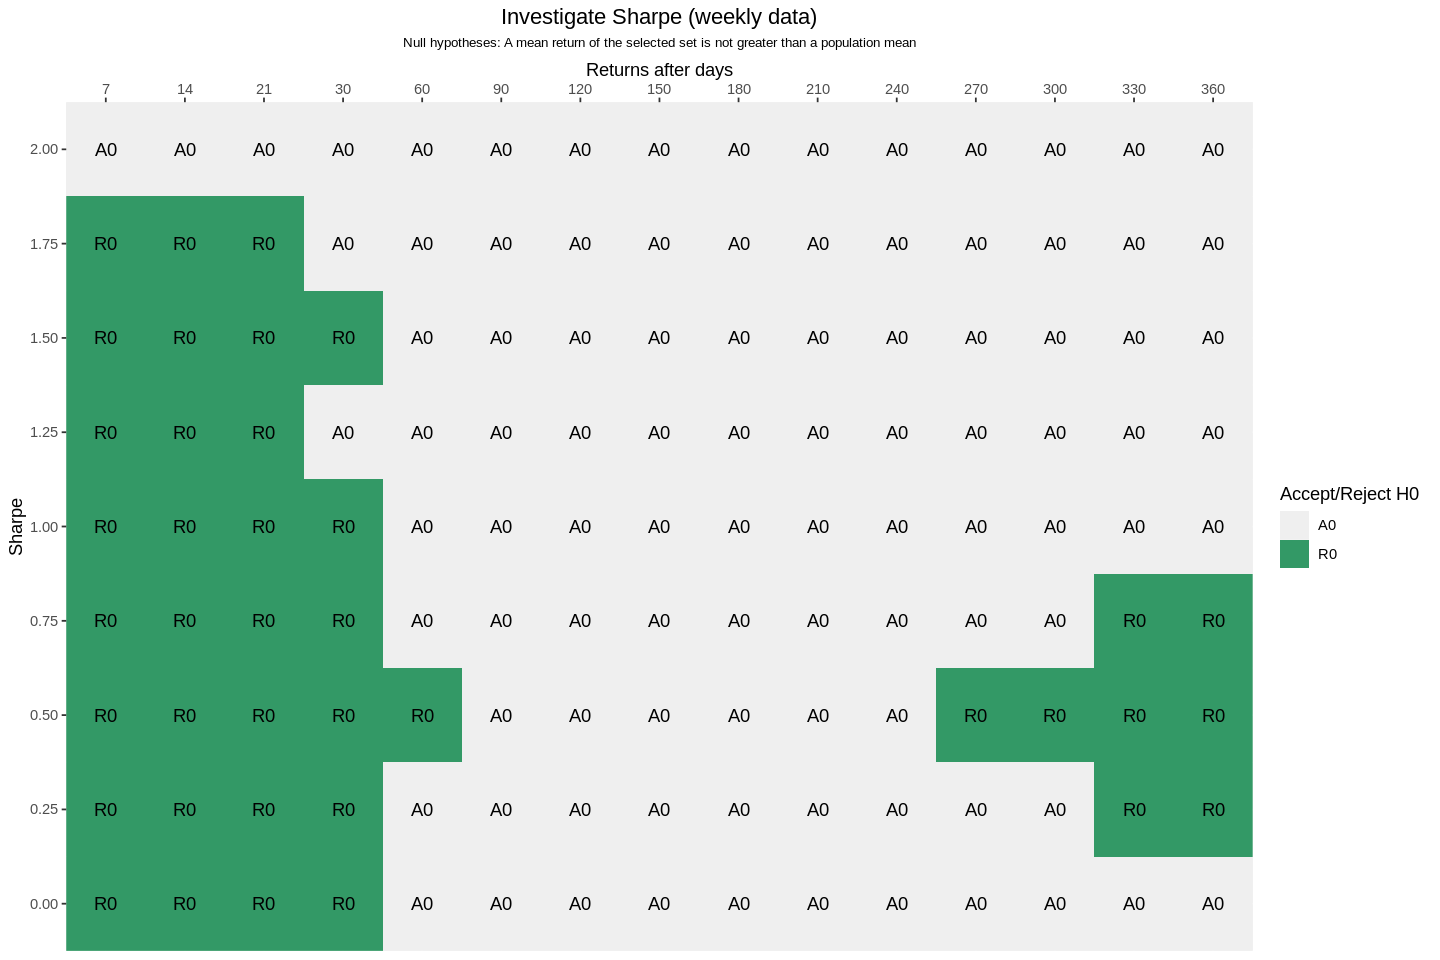

[1] ""

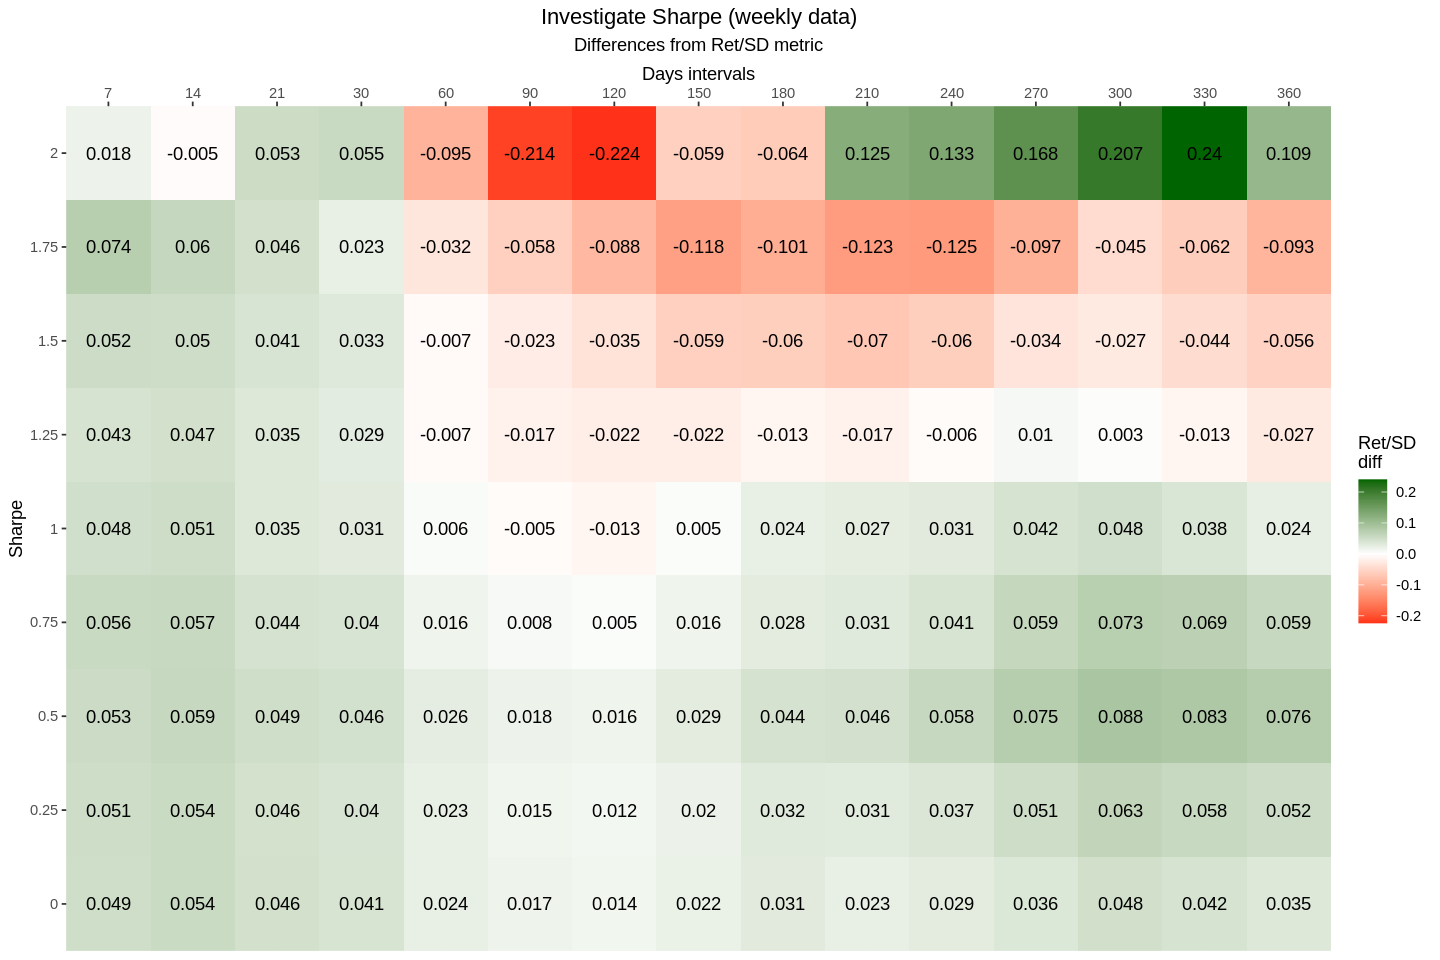

In [89]:
# makeExperiment(EXPERIMENT_Sharpe_Weekly,populationStatsData = populationStatsData)
makeExperiment(EXPERIMENT_Sharpe_Weekly)

# Sharpe calculated daily

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        2486      464130     -0.8181      0.0000     0.04094     0.04461     0.08802      1.0376     0.08525 


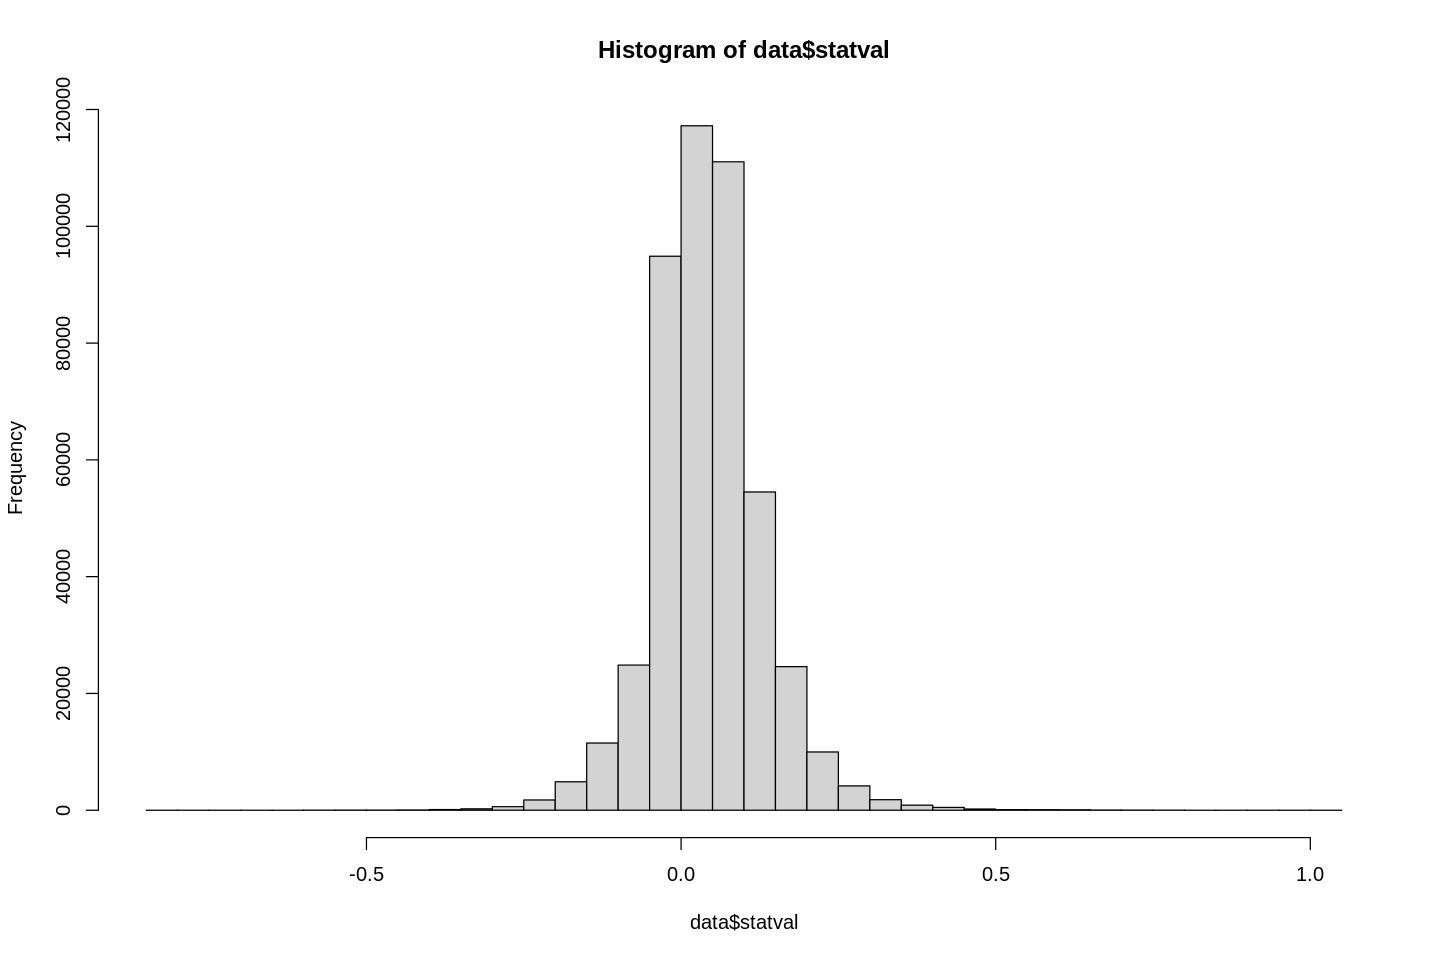

In [90]:
sql = "select Sharpe as statval, c.* from c2score_sharpe c 
       join ReturnsDataInIntervalsCleaned r on c.systemid=r.systemid and c.Date = r.DateStart
       where Age > 60"
data = getC2ScoreDbData(sql)
overview(data)
hist(data$statval,breaks=50)

No data for the attribute value 0.6 
No data for the attribute value 0.65 
No data for the attribute value 0.7 
No data for the attribute value 0.75 
No data for the attribute value 0.8 
No data for the attribute value 0.85 
No data for the attribute value 0.9 
No data for the attribute value 0.95 
No data for the attribute value 1 
Description of data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
           1      325198     4.3e-07     0.03578     0.06678     0.08217      0.1110      1.0376     0.06603 

Attribute steps:
0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1 



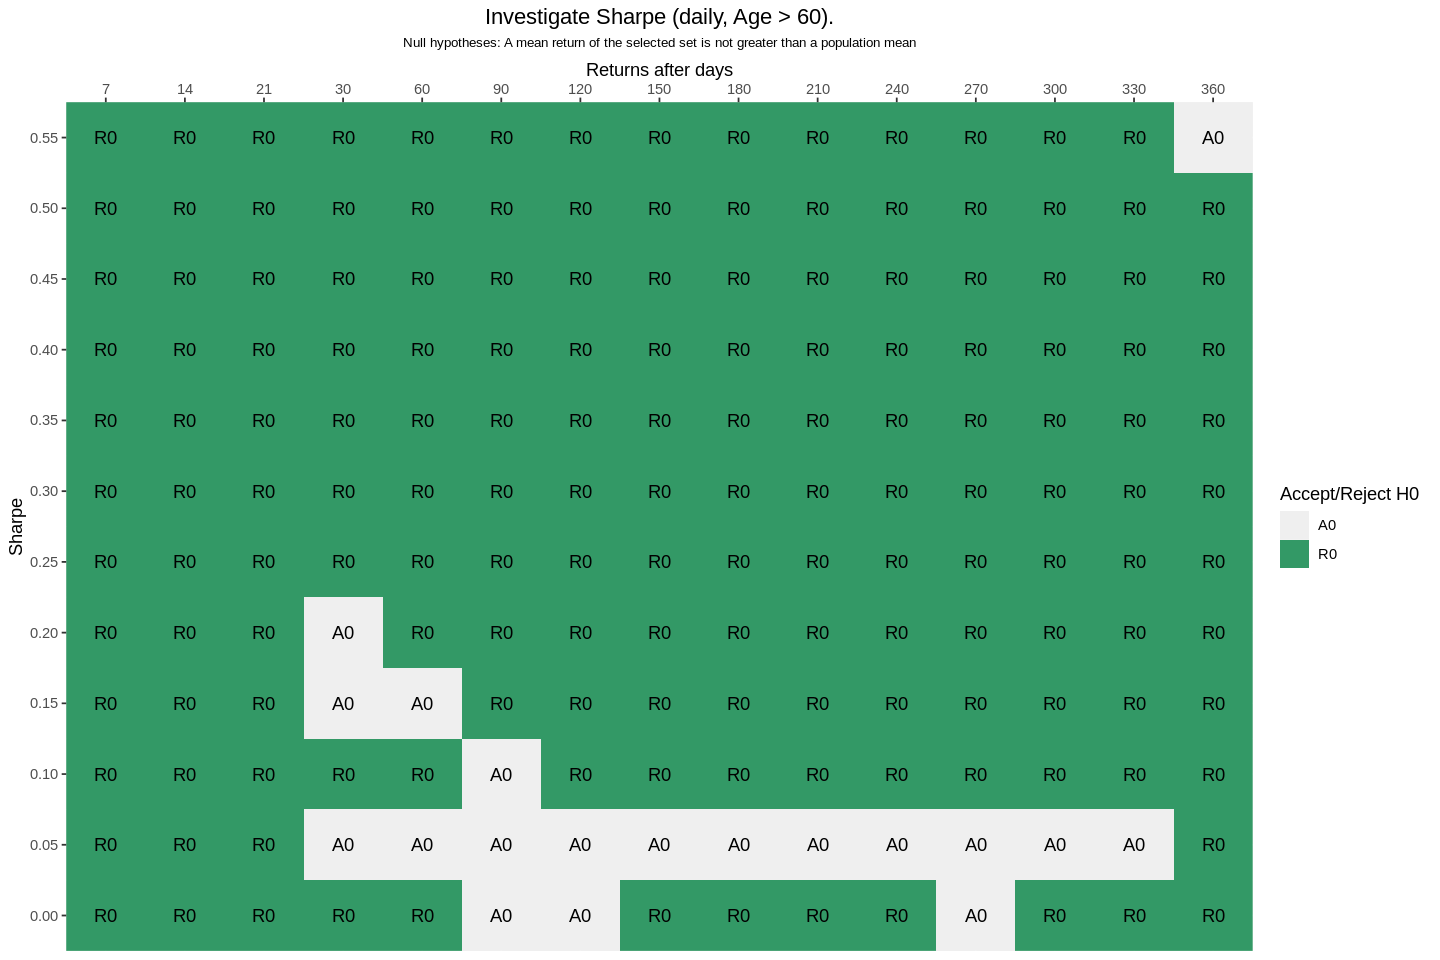

[1] ""

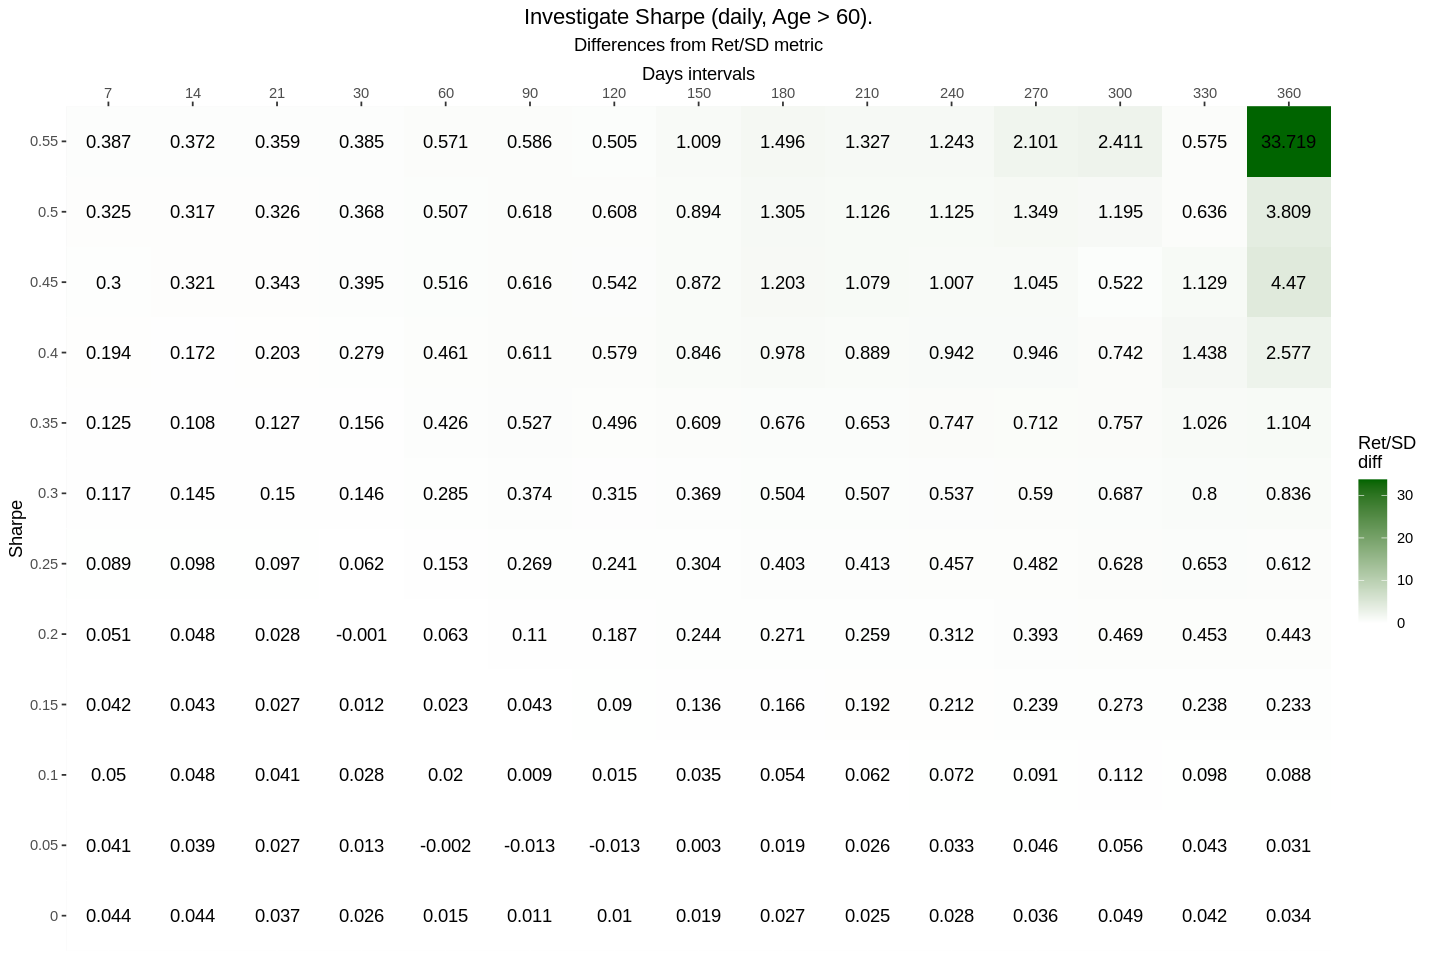

In [91]:
sql = "select * from ReturnsDataInIntervalsCleaned r 
       join c2score_sharpe c on c.systemid=r.systemid and c.Date = r.DateStart
       where Sharpe > 0 and Sharpe <= 2 and Age > 60"

experiment = list(
  name = "Sharpe daily",
  description = "Investigate Sharpe (daily, Age > 60).",
  sqlText = sql,
  attributeName = "Sharpe",
  attributeSteps = seq(from = 0, to = 1.04, by = 0.05),
  comparisonOperator = `>=`)
makeExperiment(experiment)

In [11]:
# Sharpe values seem to be in the wide range.
# Lets look at some example where sharpe < -50 and sharpe > 50
sql = "select count(distinct(systemid)) as Count from historical_stats_modern where statname='jSharpe' and statval < -50";
sharpeLow = getC2ScoreDbData(sql)
sql = "select count(distinct(systemid)) as Count from historical_stats_modern where statname='jSharpe' and statval > 50";
sharpeHigh = getC2ScoreDbData(sql)
sql = "select count(distinct(systemid)) as Count from historical_stats_modern where statname='jSharpe'";
sharpeSystems = getC2ScoreDbData(sql)

cat("----------- Sharpe < -50 and Sharpe > 50 -----------\n")

cat("Systems with very low Sharpe:",sharpeLow$Count,"\n")
cat("Systems with very high Sharpe:",sharpeHigh$Count,"\n")
cat("All systems with Sharpe:",sharpeSystems$Count,"\n")
cat("\nThere are some outliers there, but not too many. We can omit them if needed.\n")


cat("\n----------- Sharpe < -10 and Sharpe > 10 -----------\n")

sql = "select count(distinct(systemid)) as Count from historical_stats_modern where statname='jSharpe' and statval < -10";
sharpeLow = getC2ScoreDbData(sql)
sql = "select count(distinct(systemid)) as Count from historical_stats_modern where statname='jSharpe' and statval > 10";
sharpeHigh = getC2ScoreDbData(sql)

cat("Systems with Sharpe < -10:",sharpeLow$Count,"\n")
cat("Systems with Sharpe > 10:",sharpeHigh$Count,"\n")
cat("\nWell, this is a different picture....\n")


----------- Sharpe < -50 and Sharpe > 50 -----------
Systems with very low Sharpe: 52 
Systems with very high Sharpe: 18 
All systems with Sharpe: 7079 

There are some outliers there, but not too many. We can omit them if needed.

----------- Sharpe < -10 and Sharpe > 10 -----------
Systems with Sharpe < -10: 1731 
Systems with Sharpe > 10: 2084 

Well, this is a different picture....


In [12]:
# Let's look at data where Sharpe > 10. Not too old and not too young systems. 
sql = "select * from historical_stats_modern 
        where statname='jSharpe' 
        and statval > 10 
        and YYYYMMDD > 20200101";
sharpe = getC2ScoreDbData(sql)
head(sharpe)
summary(sharpe$statval)


,guid,systemid,YYYYMMDD,statname,statval,writtenWhen
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,11017455,115806986,20200106,jSharpe,10.89,2020-01-07 22:52:29
2,11065827,126828947,20200106,jSharpe,22.24,2020-01-07 23:53:56
3,11065868,126829027,20200106,jSharpe,24.98,2020-01-07 23:53:56
4,11065991,126838810,20200106,jSharpe,17.99,2020-01-07 23:54:03
5,11066067,126847594,20200106,jSharpe,11.75,2020-01-07 23:54:03
6,11066143,126853202,20200106,jSharpe,15.86,2020-01-07 23:54:26


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.02   11.59   13.89   15.00   16.61   97.34 

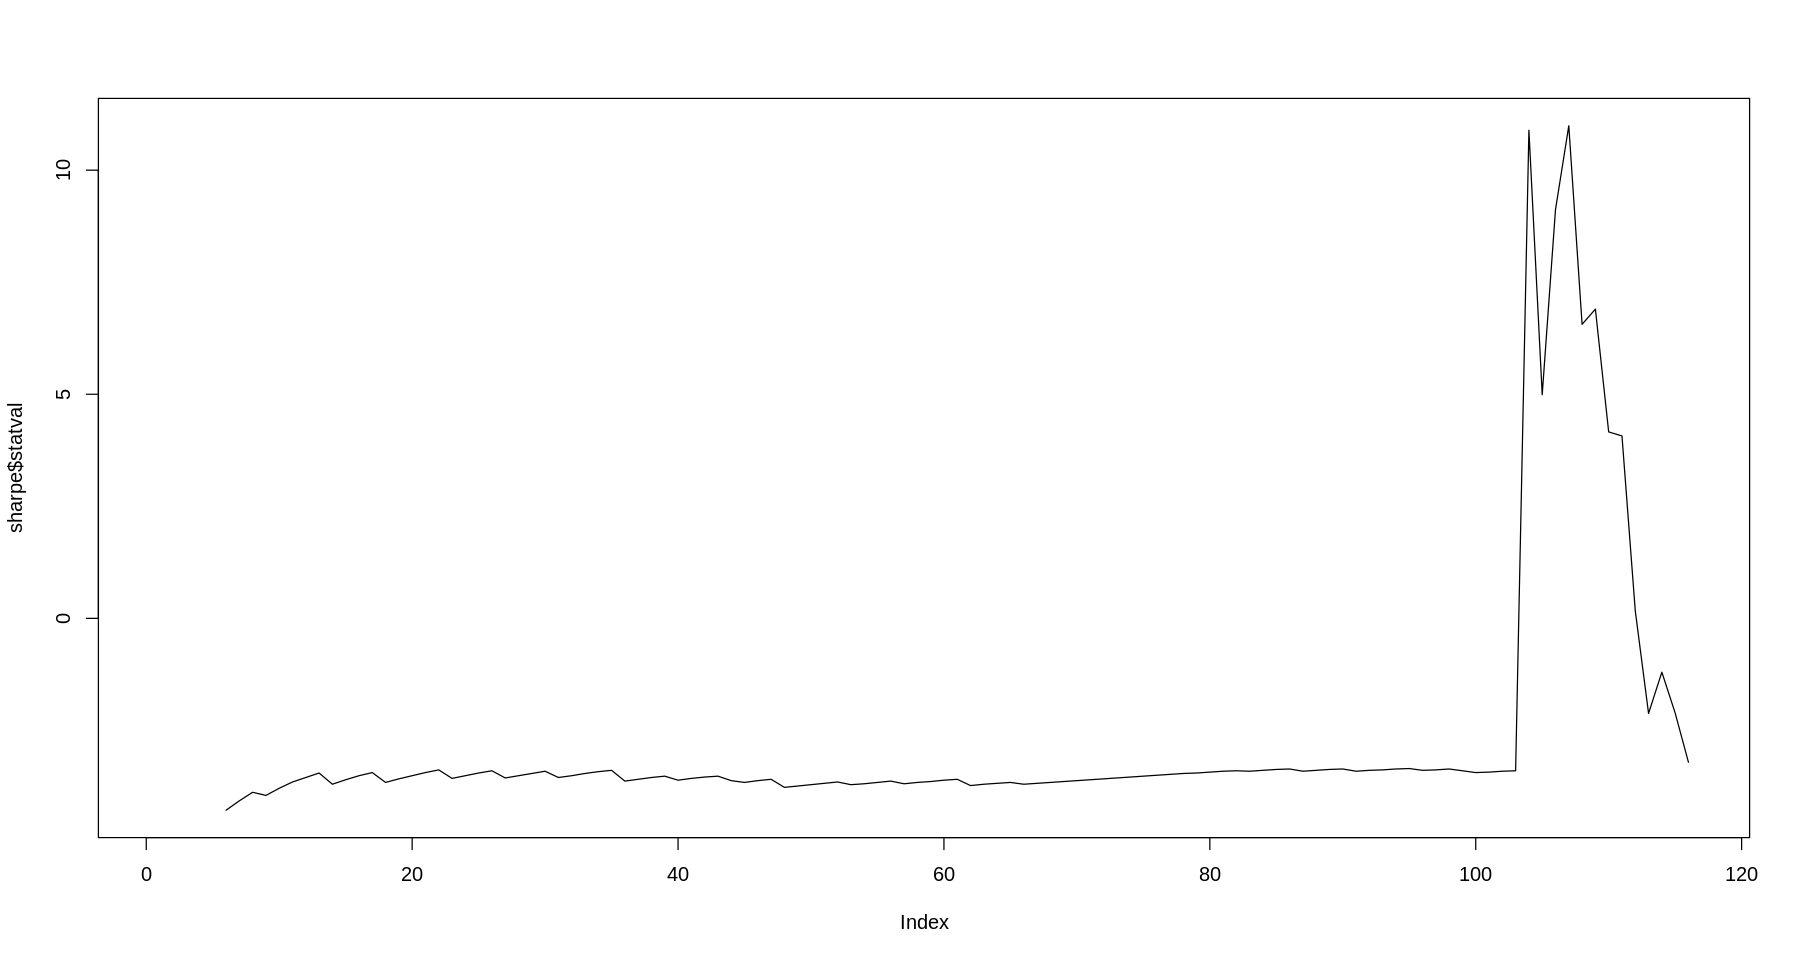

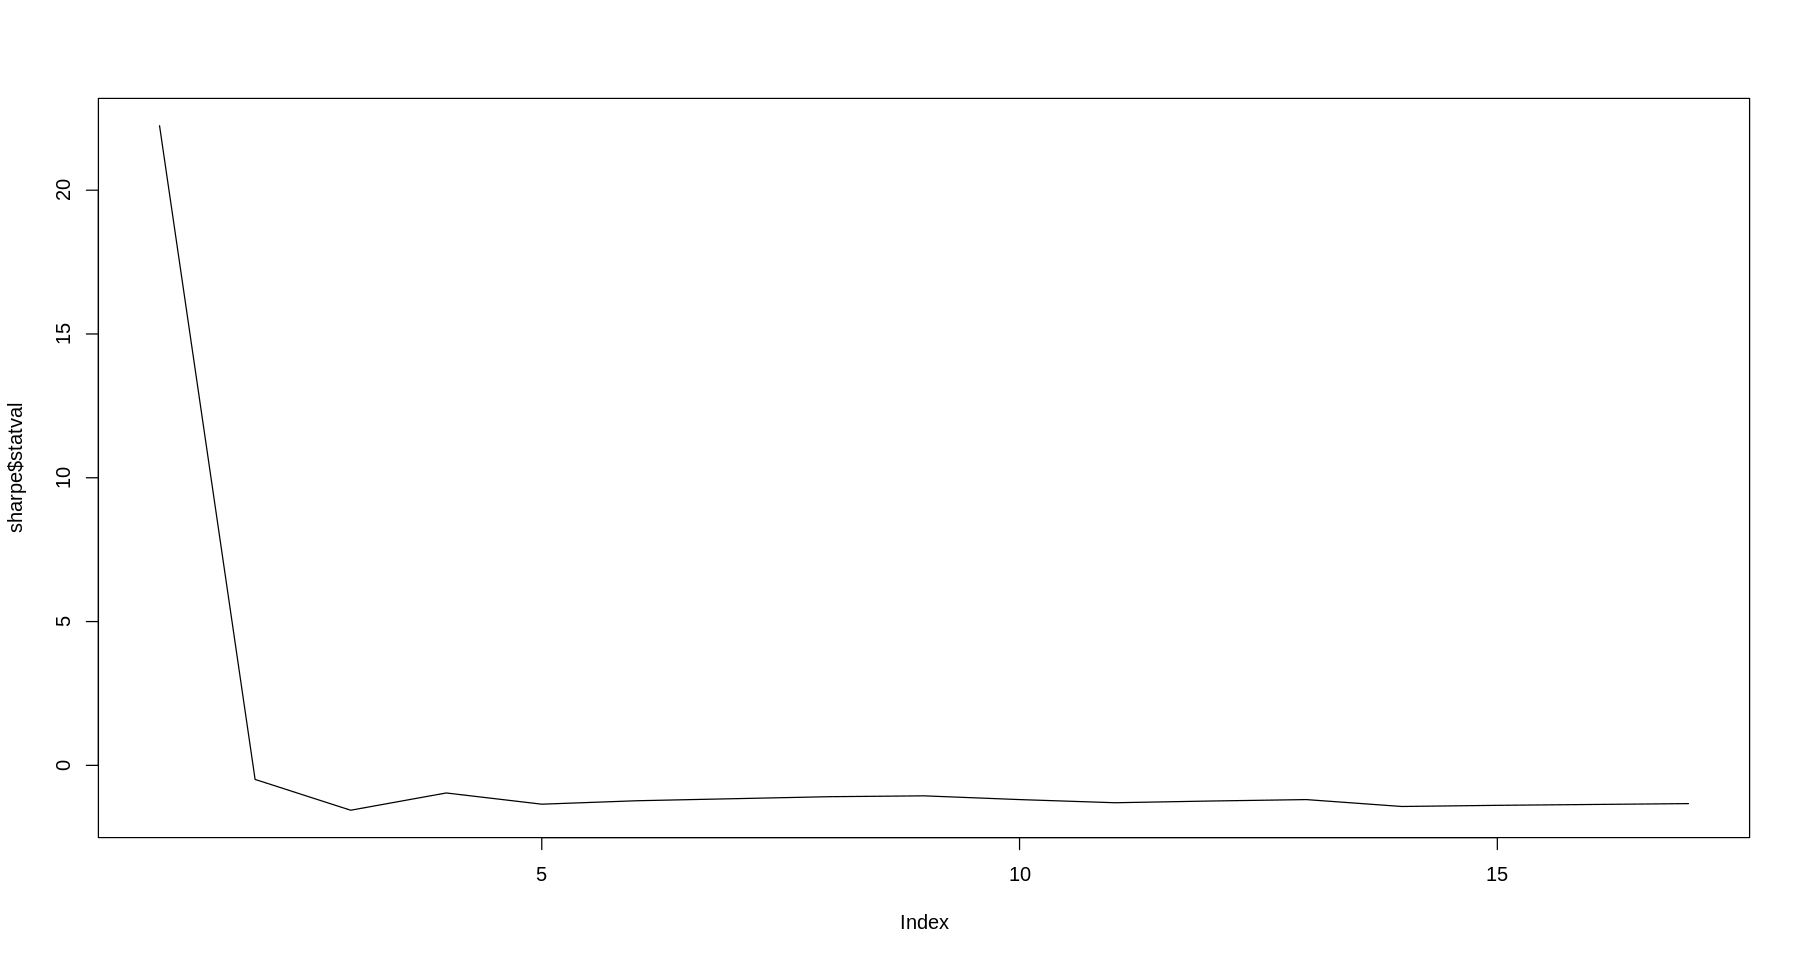

In [13]:
# Let's look at two first of them. The first and the last systems.

options(repr.plot.width=15, repr.plot.height=8)

sql = "select * from historical_stats_modern where statname='jSharpe' and systemid = 115806986"; 
sharpe = getC2ScoreDbData(sql)
# head(sharpe);tail(sharpe)
plot(sharpe$statval,type="line")

sql = "select * from historical_stats_modern where statname='jSharpe' and systemid = 126828947";
sharpe = getC2ScoreDbData(sql)
# head(sharpe);tail(sharpe)
plot(sharpe$statval,type="line")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -8.990   4.242   5.580   4.089   5.933   6.340 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -9.140   2.380   2.835   2.468   3.203   3.890 

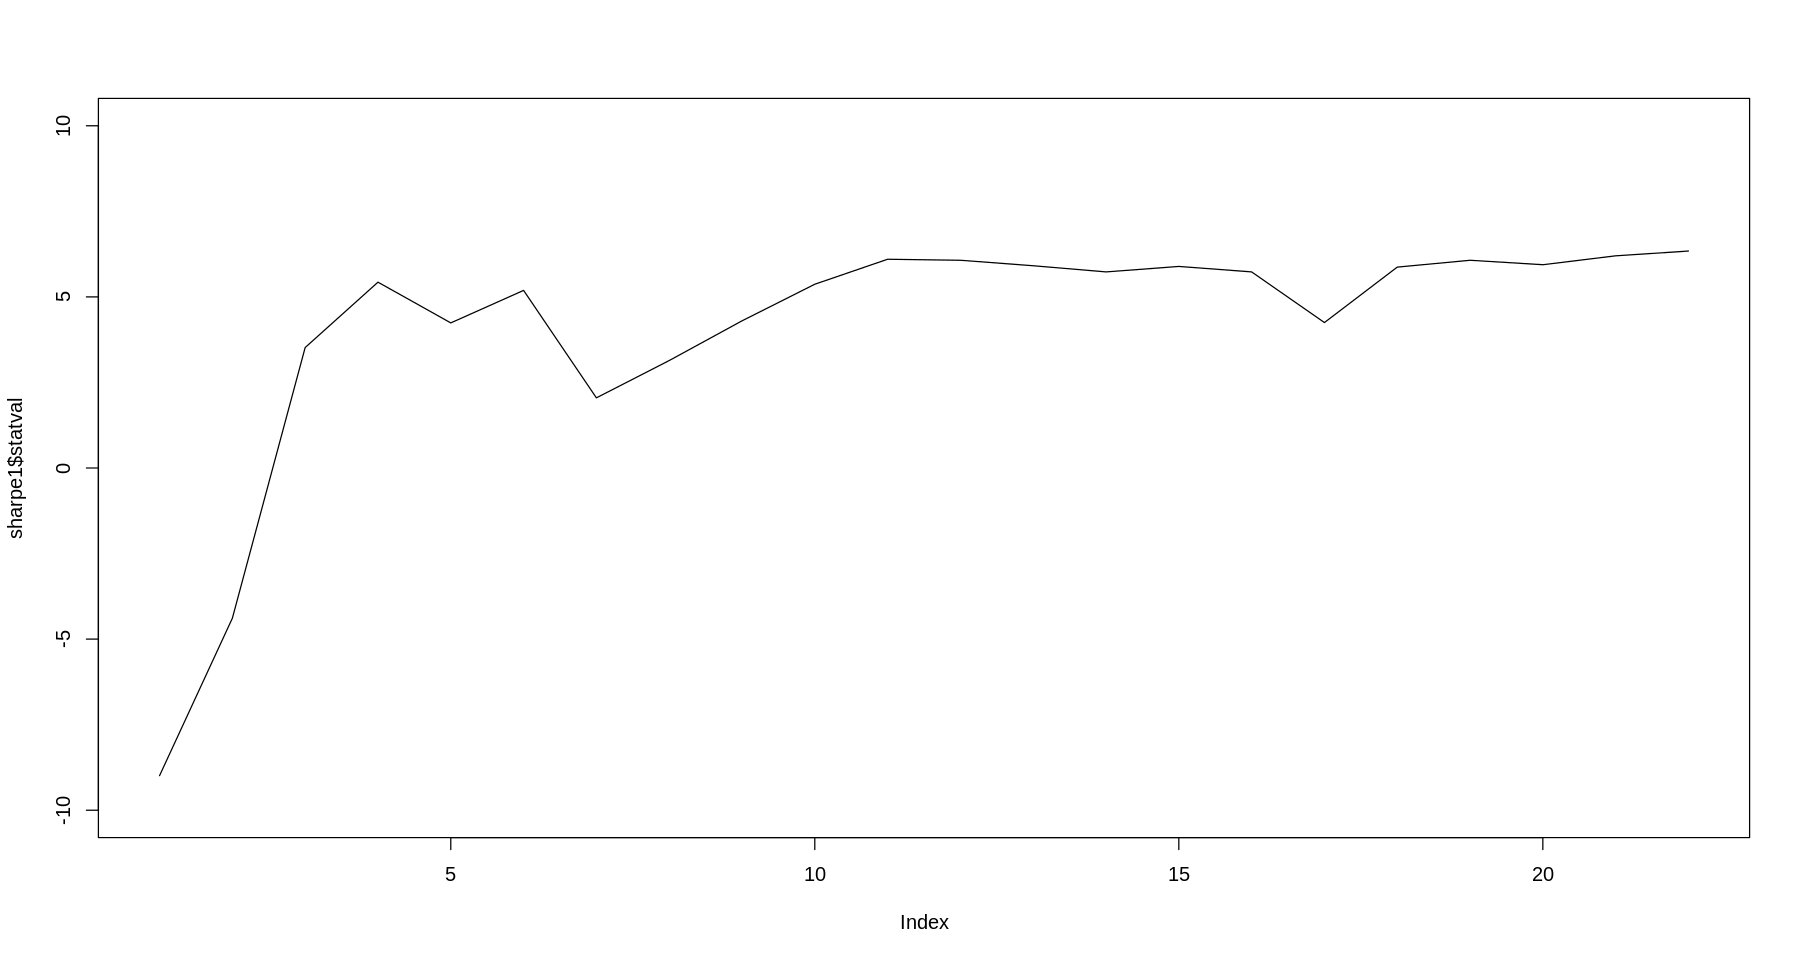

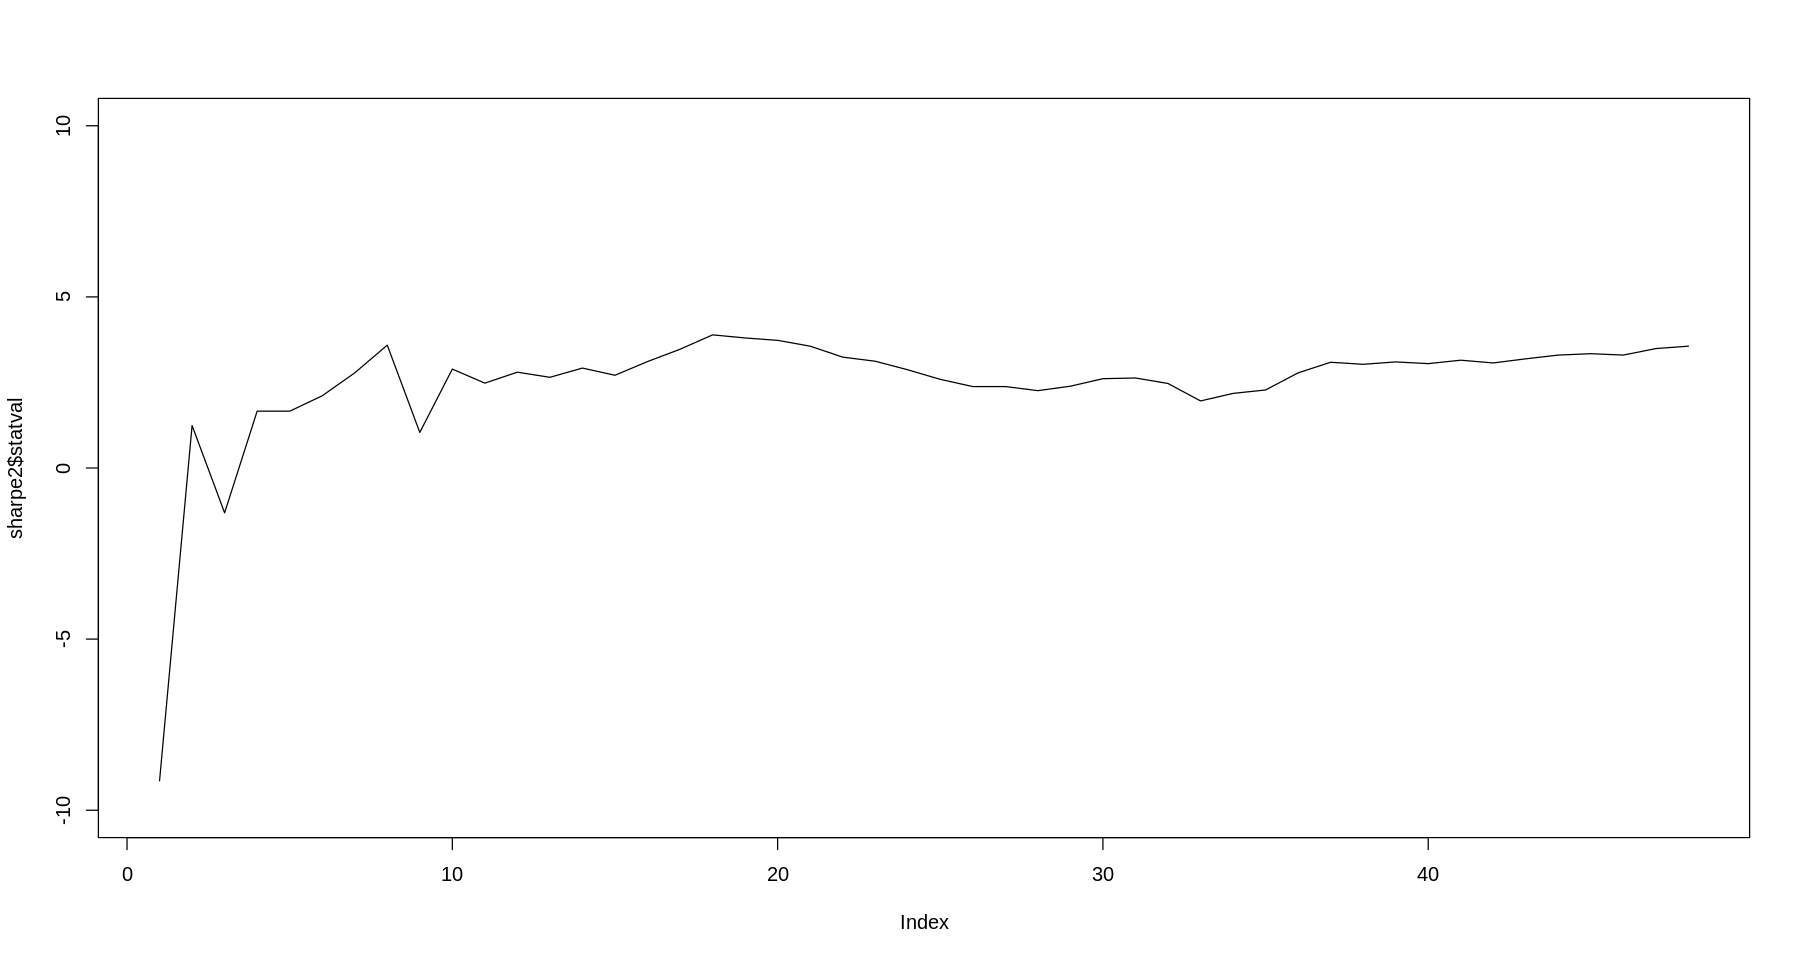

In [14]:
# It looks somewhat wild...
# Lets try something more recent. The two first systems which are currently (2021-02-23) in Leaderboard: 
# https://collective2.com/details-list/131202173
# https://collective2.com/details-list/128090640

sql = "select * from historical_stats_modern where statname='jSharpe' and systemid = 131202173"; 
sharpe1 = getC2ScoreDbData(sql)
summary(sharpe1$statval)

sql = "select * from historical_stats_modern where statname='jSharpe' and systemid = 128090640";
sharpe2 = getC2ScoreDbData(sql)
summary(sharpe2$statval)

plot(sharpe1$statval,type="line",ylim=c(-10,10))
plot(sharpe2$statval,type="line",ylim=c(-10,10))



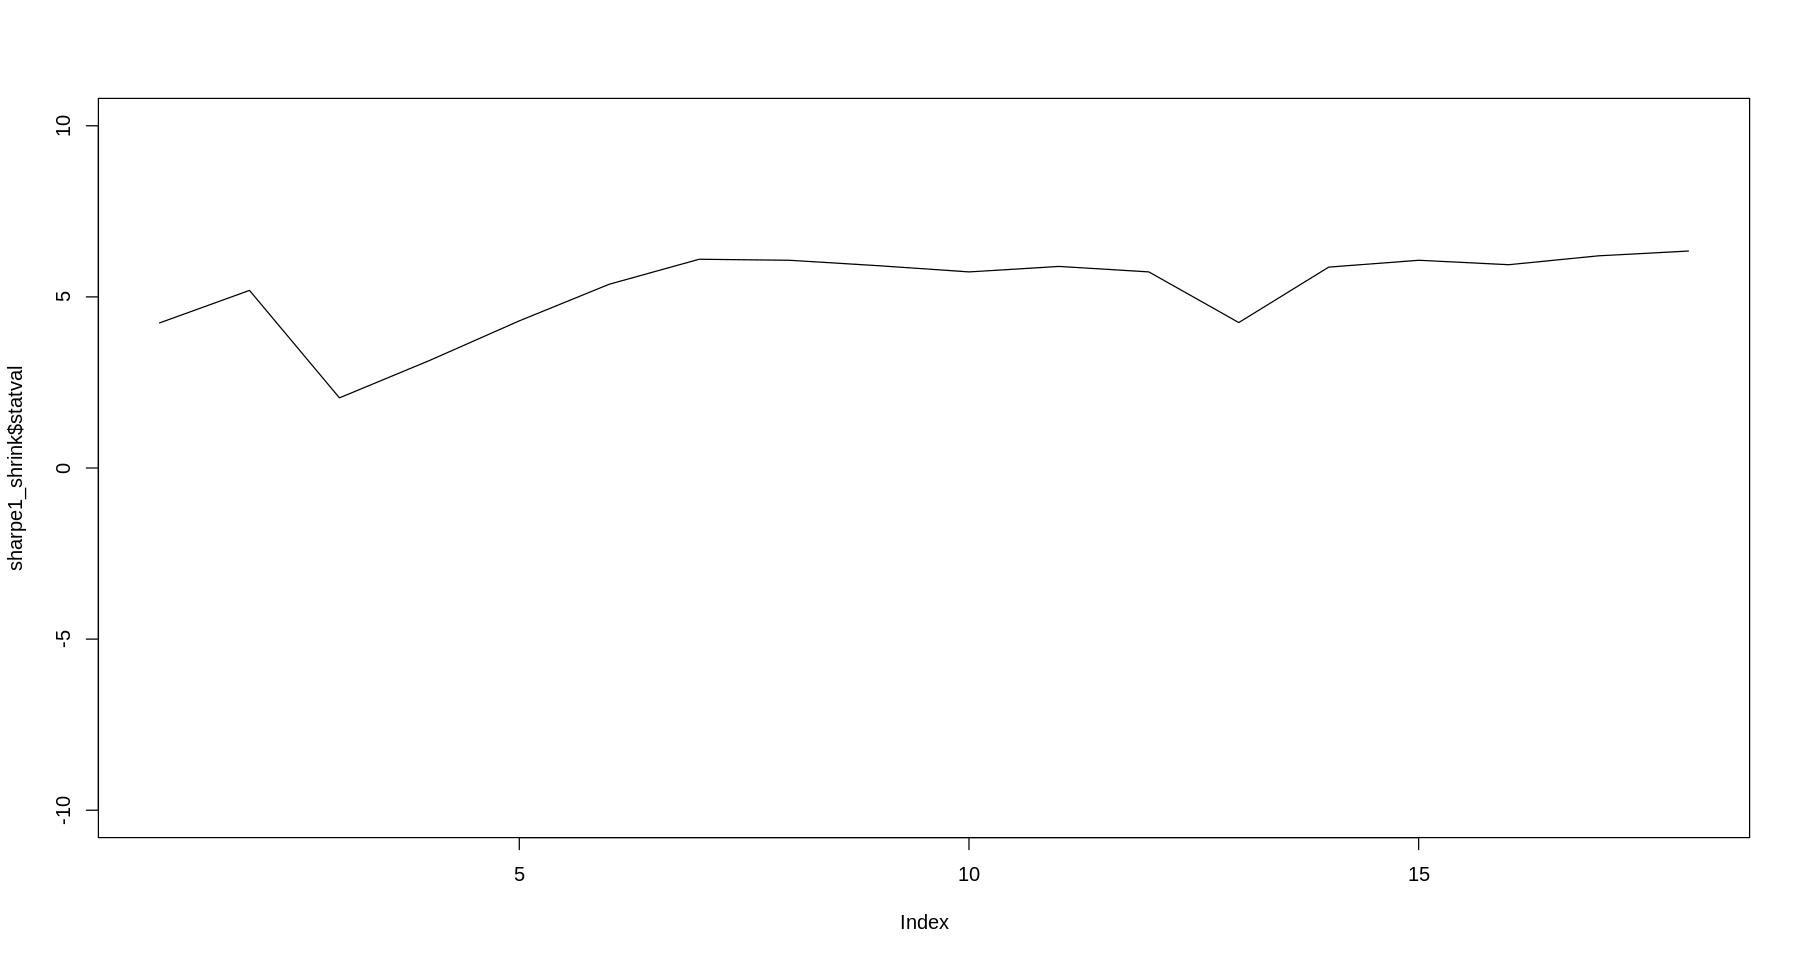

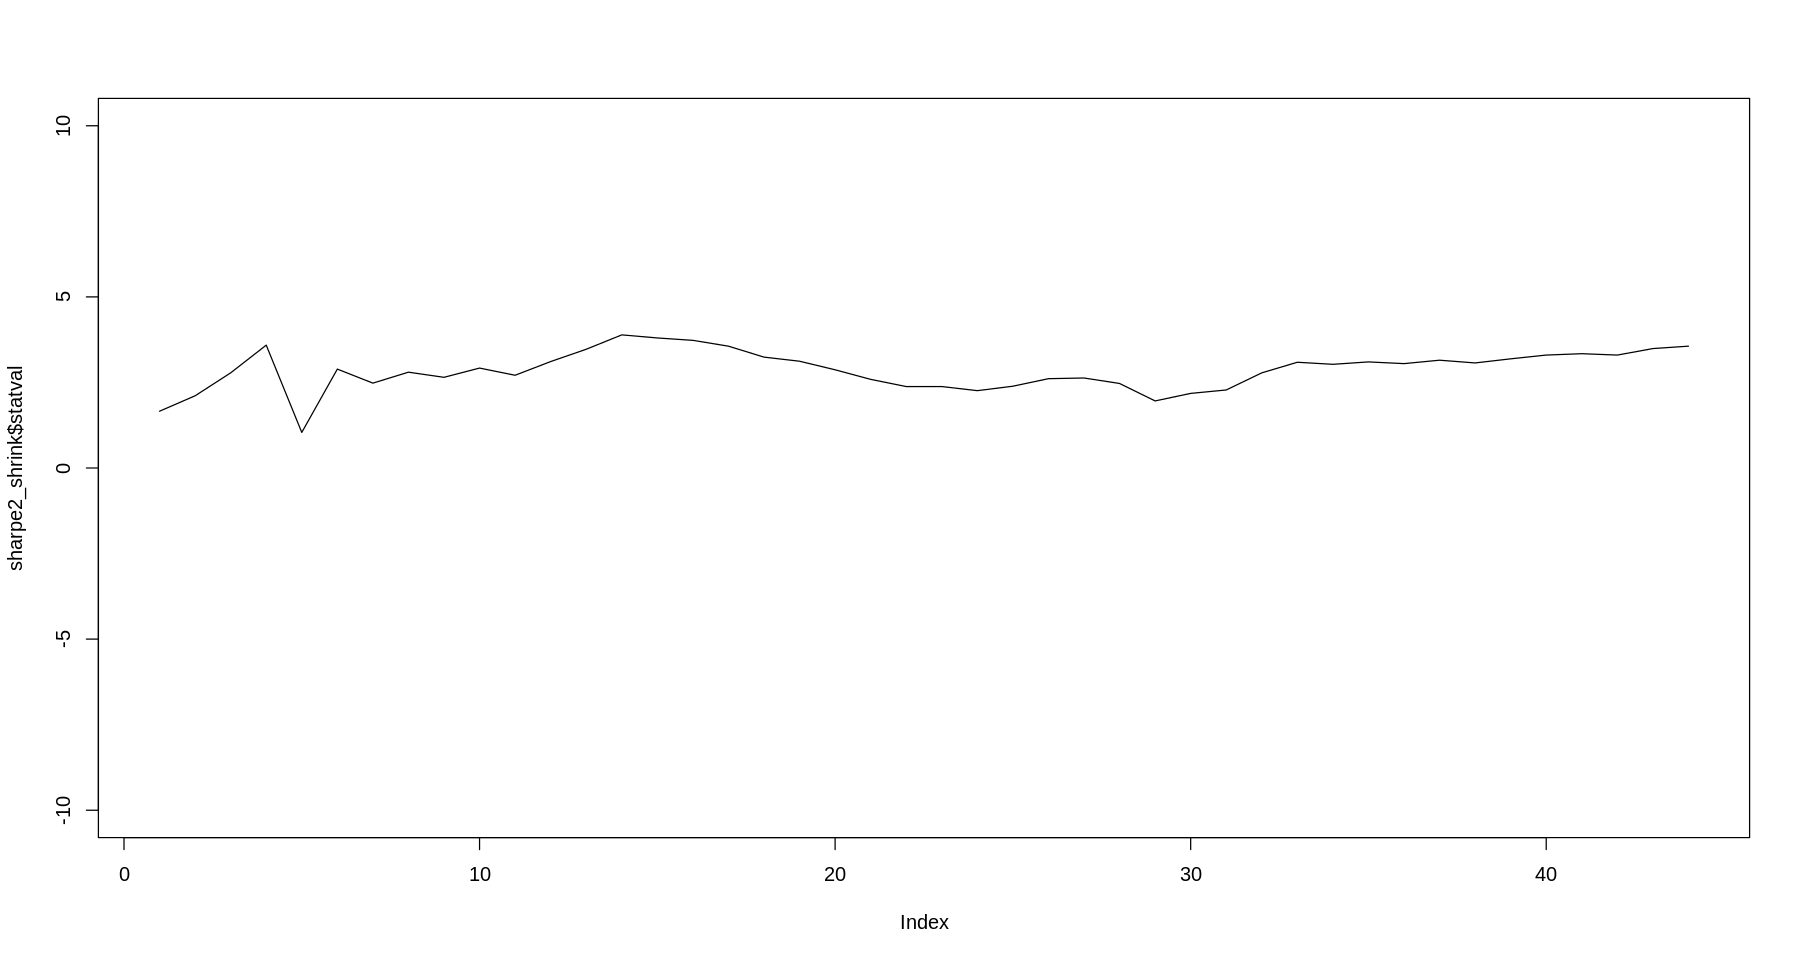

In [15]:
# It looks better, but the first values look like calculation needs some time to stabilize.
# Let's omit first 4 values. That is the first 4 weeks. Data are calculated weekly.
sharpe1_shrink = tail(sharpe1,-4)
sharpe2_shrink = tail(sharpe2,-4)
plot(sharpe1_shrink$statval,type="line",ylim=c(-10,10))
plot(sharpe2_shrink$statval,type="line",ylim=c(-10,10))

Better. However... it seems that Sharpe calculations should have a better quality.
It seems it is calculated too early after the system start. I guess it needs more observations.

Collective2 calculates statistics weekly. Perhaps systems which do large moves over a week have too big jumps in returns and weekly Sharpe jumps up and down then. 

## Investigate Sharpe

Let's visualize population average 30 days return and the same return for systems ahaving Sharpe > 2.

30 days returns


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.000000 -0.017885  0.000276  0.002393  0.040293  0.944394 

Number of observations = 535448  SD =  0.1267285 


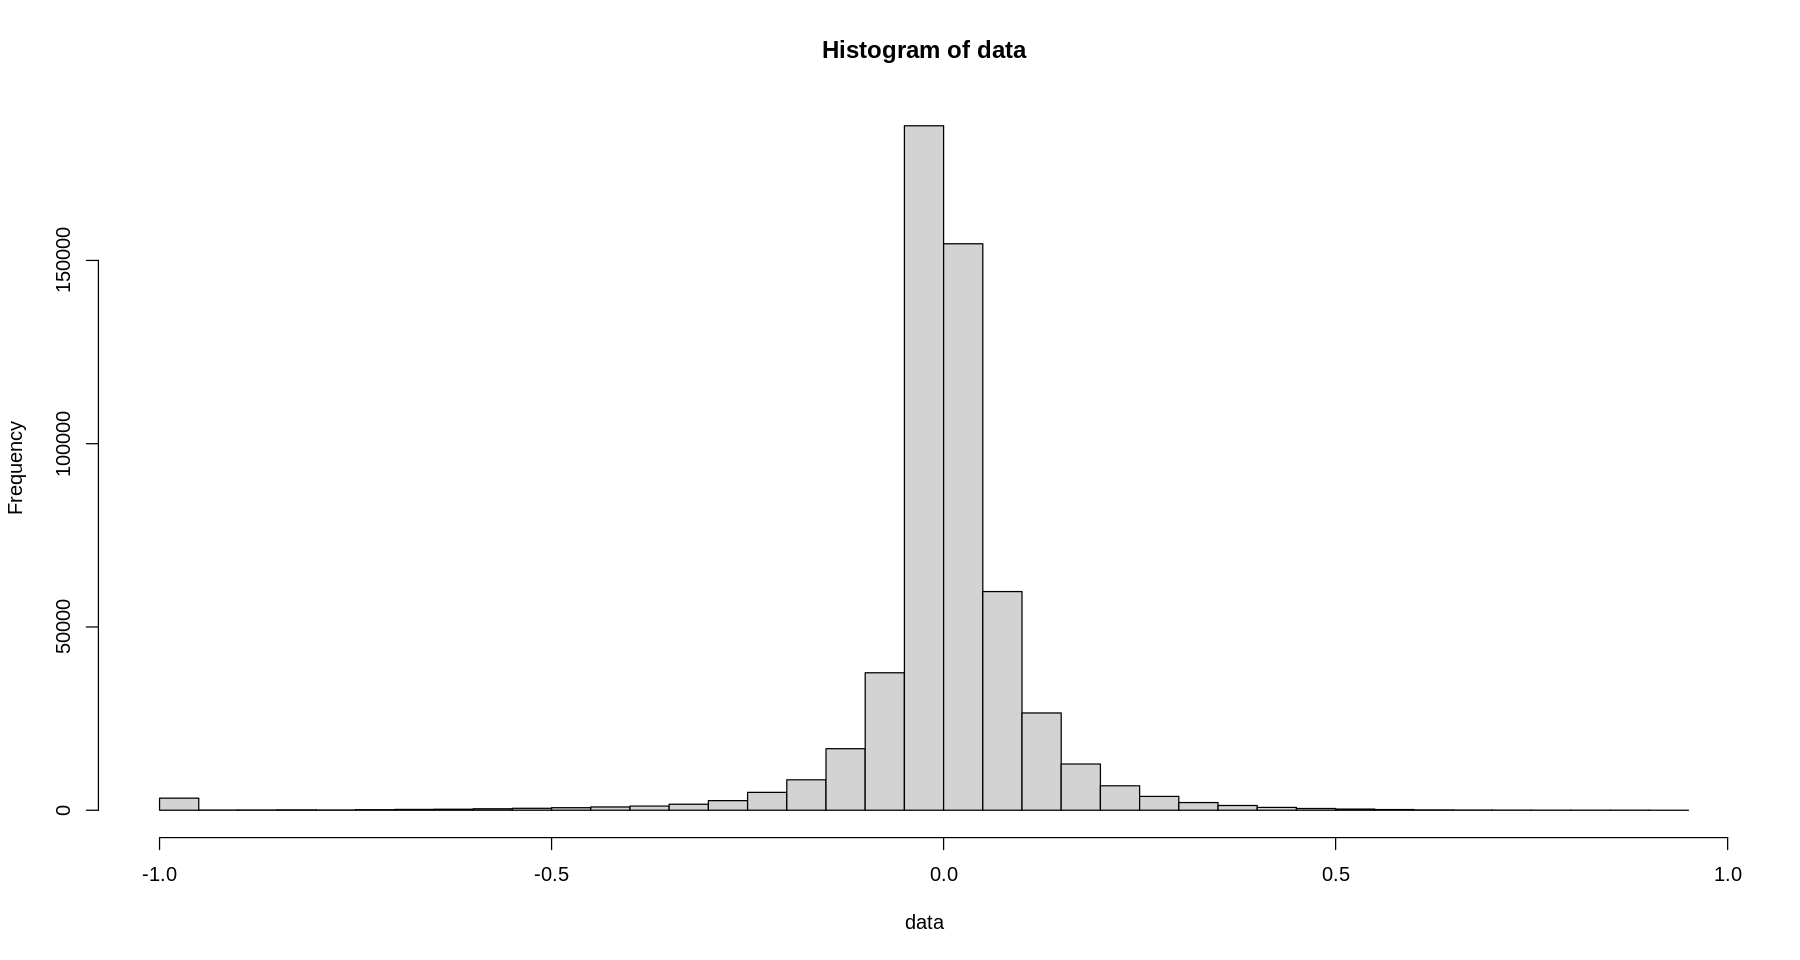

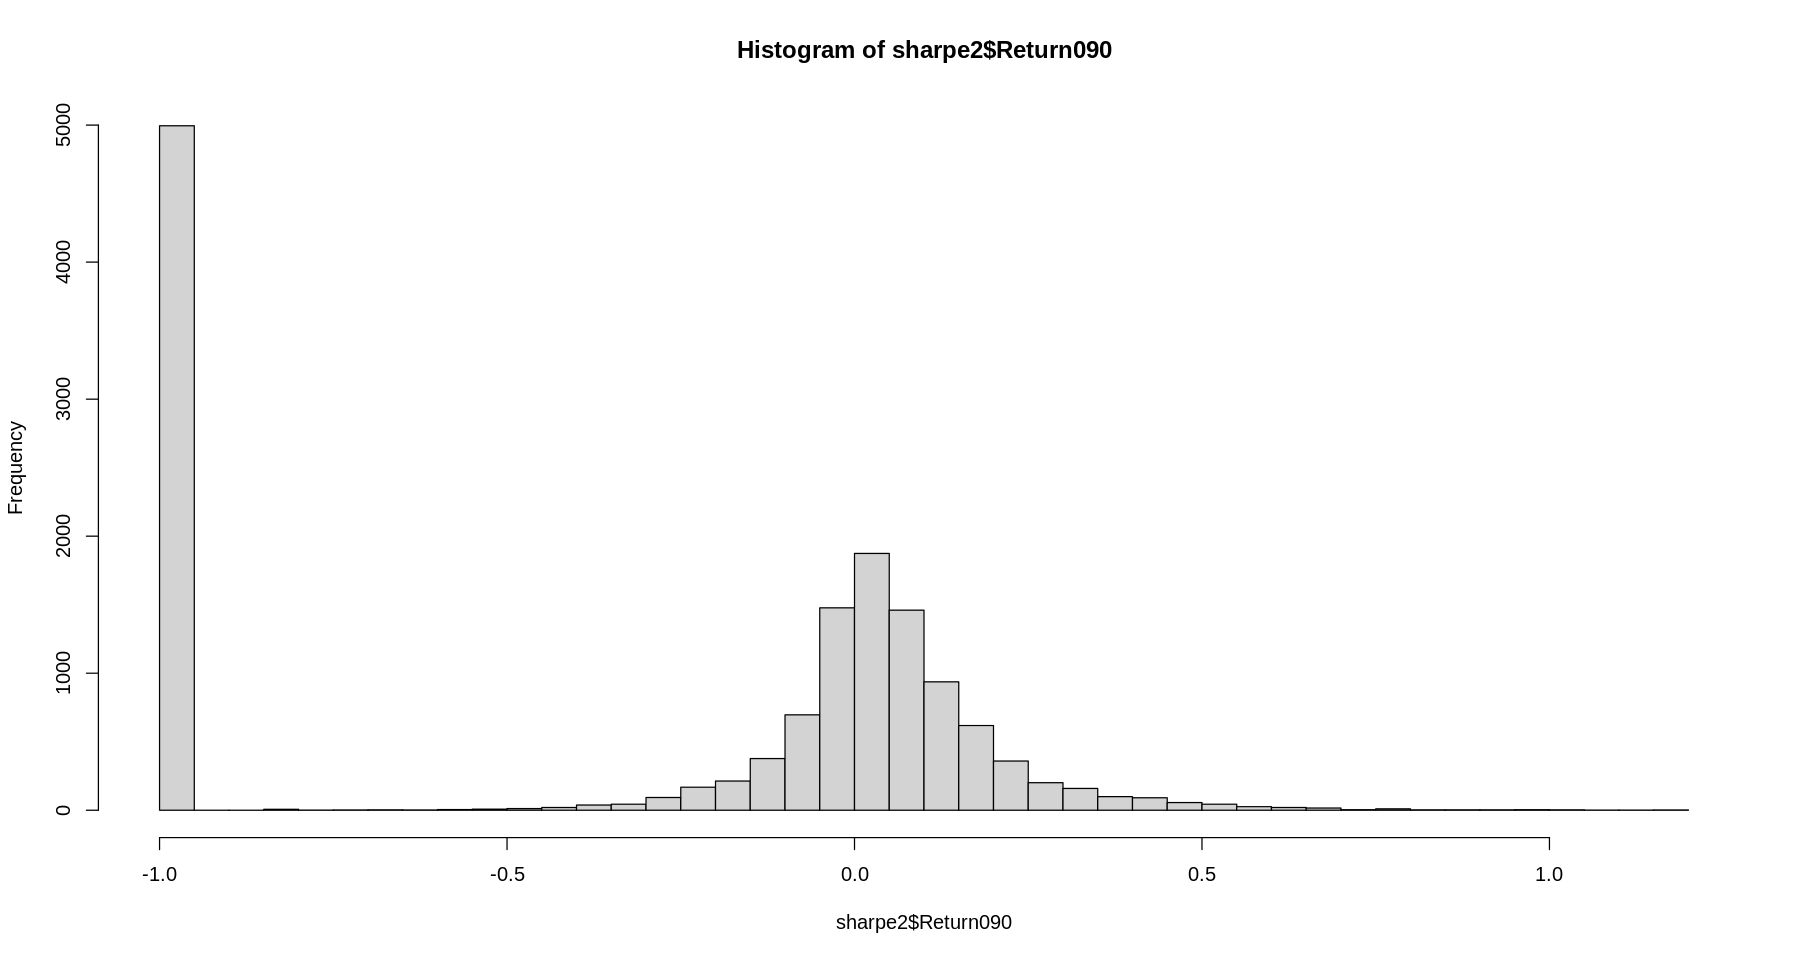

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.00000 -1.00000 -0.03196 -0.31985  0.06754  1.19031 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.00000 -1.00000 -1.00000 -0.49169  0.06559  1.66670 

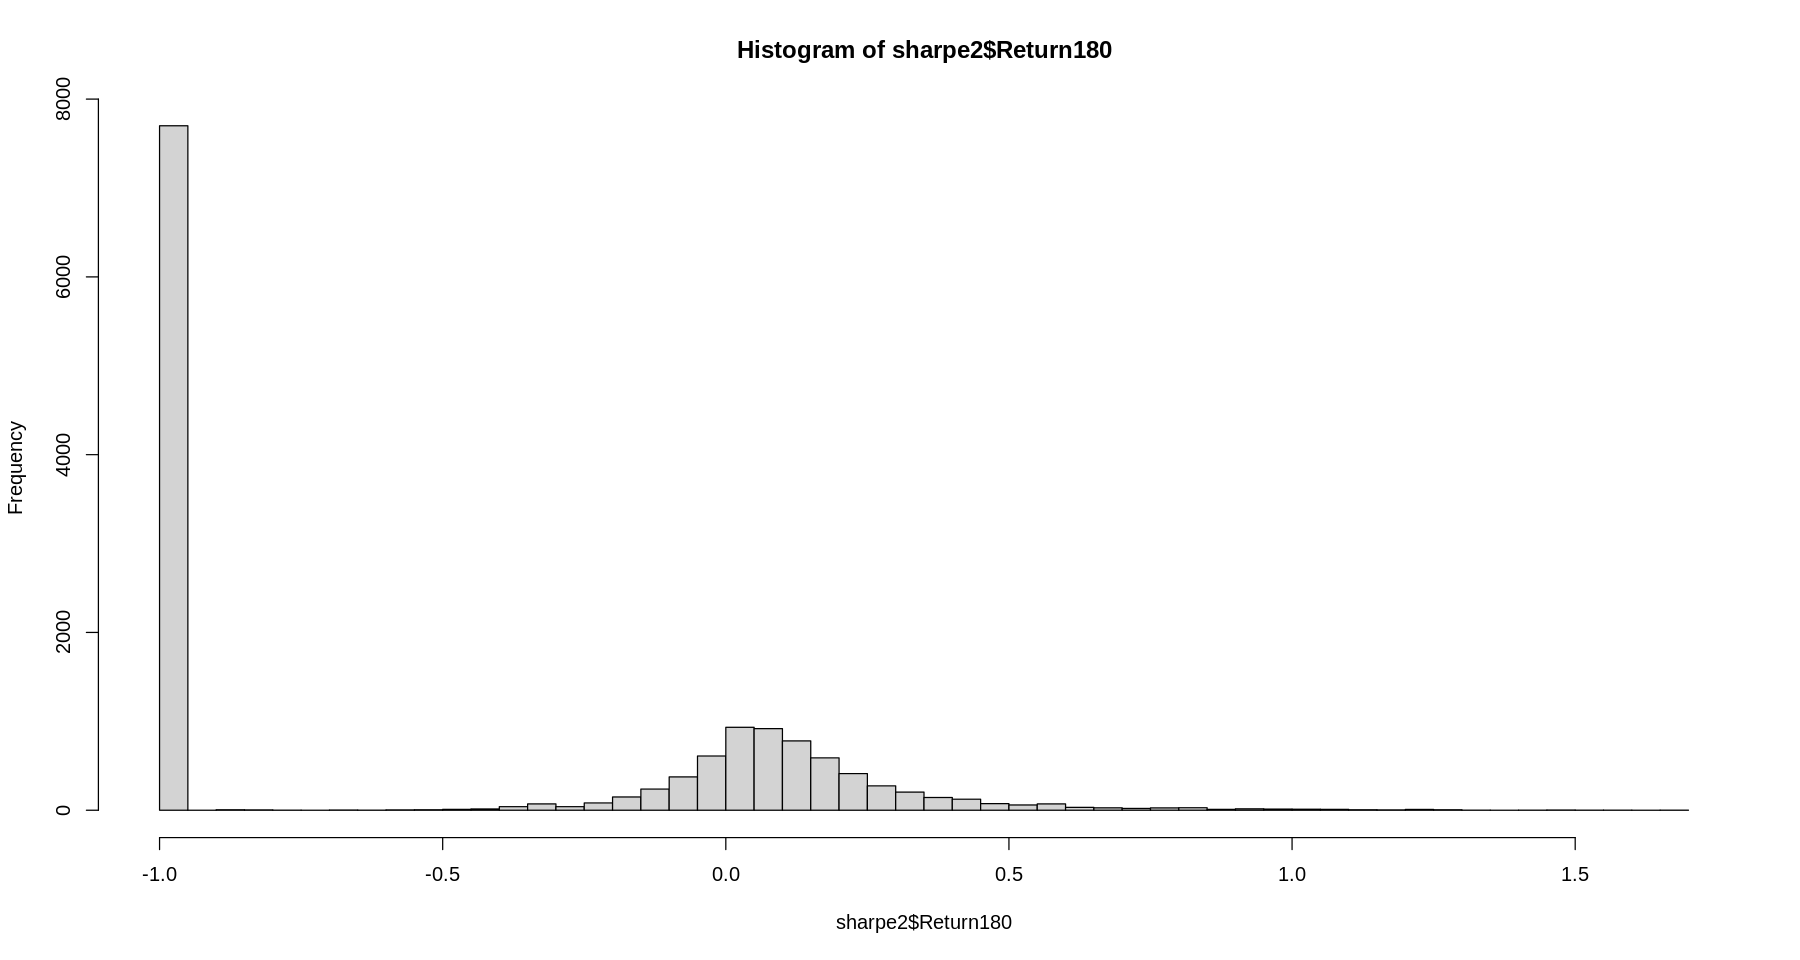

In [16]:
cat("30 days returns\n")
stats = getC2ScoreDbData("call PopulationStats(30);")
# head(stats); tail(stats)
data = stats$Return030 
hist(data,breaks=50)
summary(data)
cat("Number of observations =",NROW(data)," SD = ",sd(data),"\n")

# ---------------------------------------
# Hypothesis for returns when Sharpe > 2 
# ---------------------------------------
sql = "select statval, eq.*
from ReturnsDataInIntervalsCleaned eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where statname='jSharpe'
 and Age > 30 # at least 30 for Sharpe 
 and statval > 2;"

sharpe2 = getC2ScoreDbData(sql)

hist(sharpe2$Return090,breaks=50)
hist(sharpe2$Return180,breaks=50)
summary(sharpe2$Return090)
summary(sharpe2$Return180)


In [17]:
sql = "select statval from
        ReturnsDataInIntervalsCleaned eq
        join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
        where statname='jSharpe'";
statval = getC2ScoreDbData(sql)

In [18]:
nrow(statval)

[1] 89554

About a half of obsevations in the C2Score database? Interesting...

We shoud have 7x less data, because the historical_stats_modern contains WEEKLY data.

It means there is probably more systems in the historical_stats_modern table than in the ReturnsDataInIntervalsCleaned.

It should be so, because ReturnsDataInIntervalsCleaned should not contain "bad" systems. But so large difference???

Yes. I looked at several systems and historical_stats_modern contains systems which are in the hidden_systems or systems wich should not be used for 

# ToDo: More details here!

select from_unixtime(startsecs),from_unixtime(endsecs), p.* from providerCreditsPackages p where systemid = 24633877; 

Result:
from_unixtime(startsecs), from_unixtime(endsecs), guid, systemid, startsecs, endsecs, package, uppGUID, disposition
 '2020-11-28 11:38:54', '2021-02-27 23:38:54', '35733', '24633877', '1606581534', '1614487134', 'basic', '1175279', NULL


select from_unixtime(whensecs), h.* from hidden_systems h where system_id = 24633877; 
 from_unixtime(whensecs), system_id, reason, guid_primary, secondaryData, whensecs

Result:
'2020-12-02 02:29:43', '24633877', 'private', '515265', NULL, '1606894183'


In [19]:
# Systems in cleaned systems ReturnsDataInIntervalsCleaned
sql = "select distinct(systemid) as NumCleaned from ReturnsDataInIntervalsCleaned";
numCleaned = getC2ScoreDbData(sql)

# Systems in historical_stats_modern
sql = "select distinct(systemid) as NumModern from historical_stats_modern";
numModern = getC2ScoreDbData(sql)


In [20]:
cat("Systems in cleaned database:",nrow(numCleaned),"\nSystems in historical_stats_modern:",nrow(numModern),"\n")
# Common systems
common = length(intersect(numCleaned$NumCleaned, numModern$NumModern))
cat("Common systems: ",common,"\n")

inClenanedOnly = length(setdiff(numCleaned$NumCleaned, numModern$NumModern))
cat("Systems present in the cleaned database but NOT present in historical_stats_modern:",inClenanedOnly,"\n")

inHistorical_stats_modernOnly = length(setdiff(numModern$NumModern,numCleaned$NumCleaned))
cat("Systems NOT present in the cleaned database but present in historical_stats_modern:",inHistorical_stats_modernOnly,"\n")


Systems in cleaned database: 5091 
Systems in historical_stats_modern: 7194 
Common systems:  4646 
Systems present in the cleaned database but NOT present in historical_stats_modern: 445 
Systems NOT present in the cleaned database but present in historical_stats_modern: 2548 


An example of the system in the Cleaned database but NOT present in historical_stats_modern

https://collective2.com/details/110269920

```
select from_unixtime(startsecs),from_unixtime(endsecs), p.* from providerCreditsPackages p where systemid = 110269920; 
```
Result:
```
from_unixtime(startsecs), from_unixtime(endsecs), guid, systemid, startsecs, endsecs, package, uppGUID, disposition
'2017-03-16 07:10:04', '2017-04-03 02:40:37', '2513', '110269920', '1489662604', '1491201637', 'basic', '2327', 'archivedTrial'
```

[1] 89554

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-434.4100   -0.5500    0.7300    0.5554    1.8700  297.4800      1365 

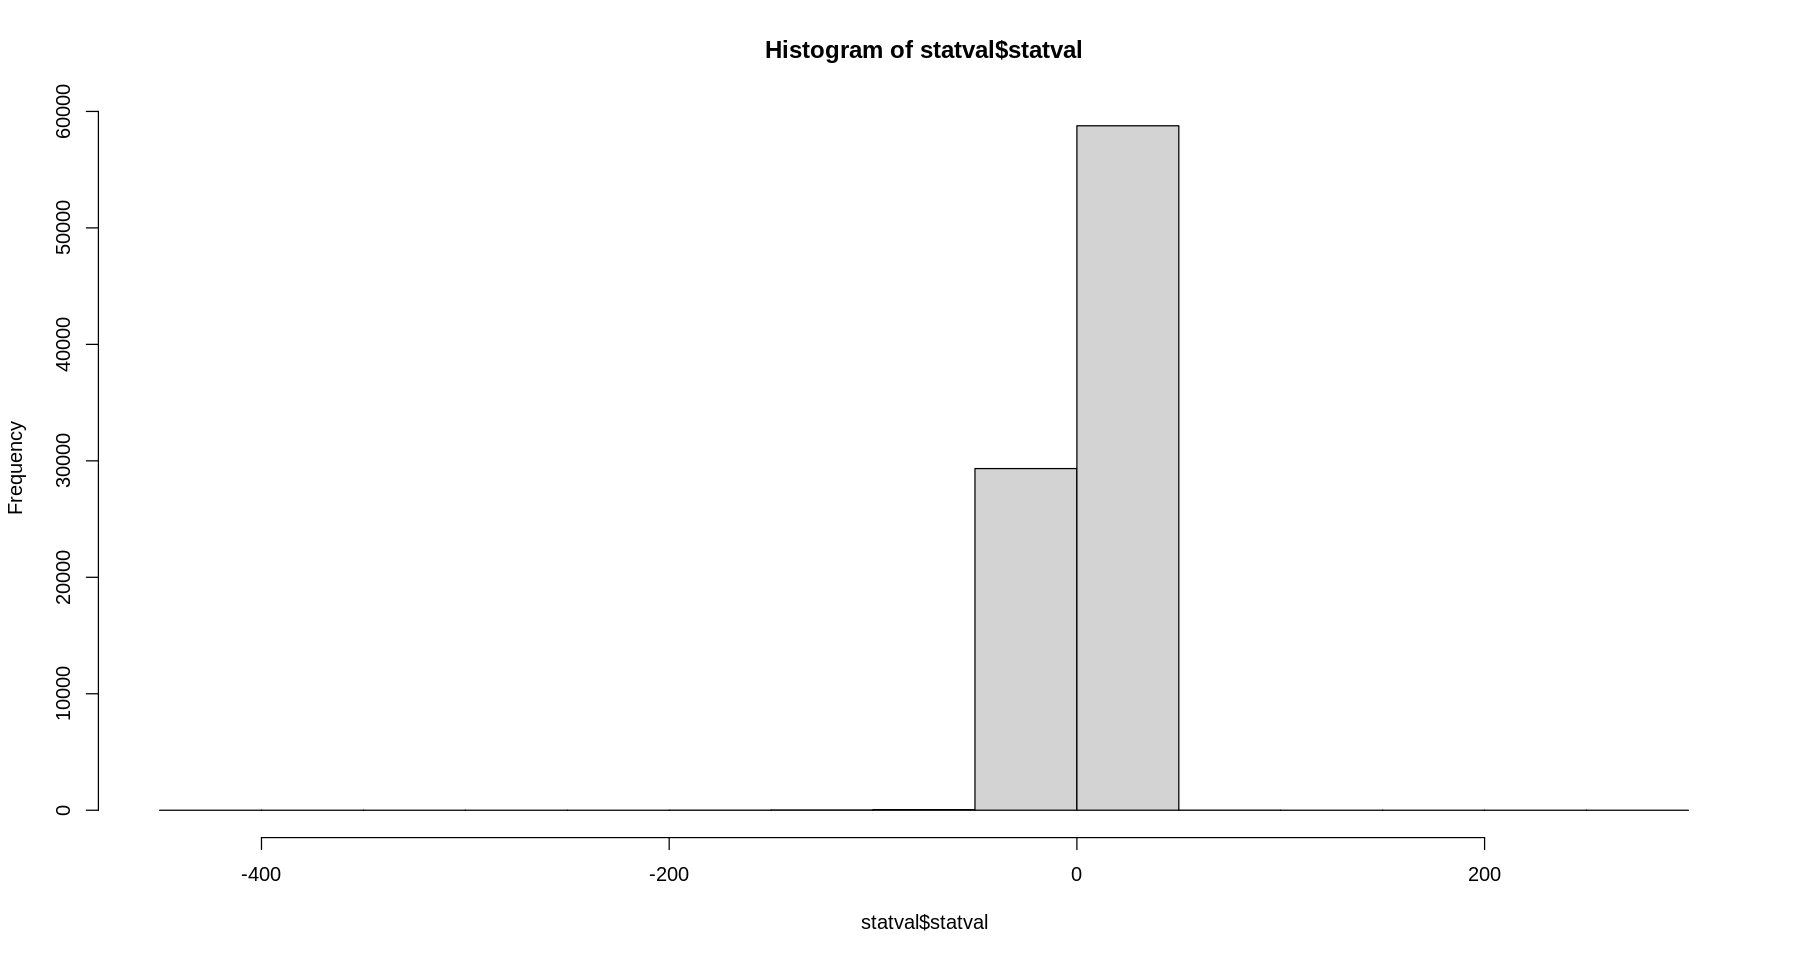

In [21]:
nrow(statval)

#statval = statval[statval > -5, ]
#statval = statval[statval < 5, ]
summary(statval$statval)
hist(statval$statval)




We have  2227 NULL values in Sharpe data
Let's get not null data where -2 < Sharpe < +2 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.9900 -0.3200  0.4400  0.3091  1.0200  1.9900 

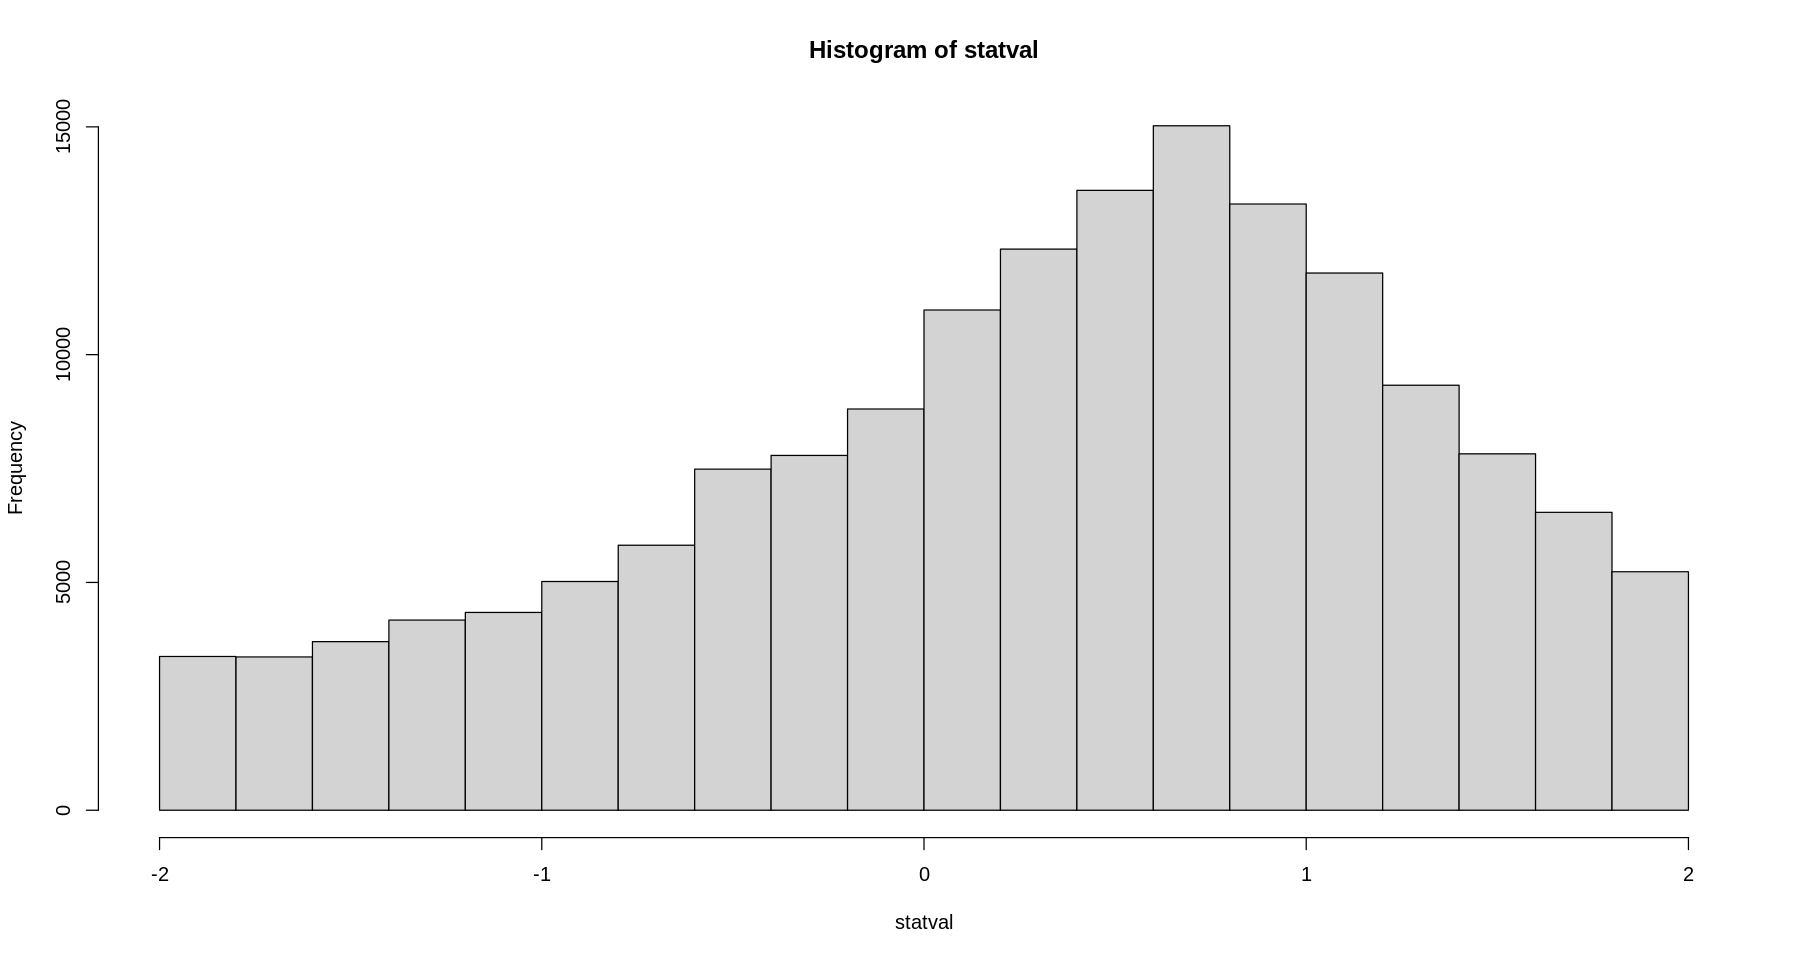

In [22]:
# Apparently there are large outliers or errors there.
# Let's try to clean the data

# NULLs:
sql = "select count(*) as Count from historical_stats_modern where statname='jSharpe' and statval is null";
sharpeNulls = getC2ScoreDbData(sql)

cat("We have ",sharpeNulls$Count,"NULL values in Sharpe data\n")

cat("Let's get not null data where -2 < Sharpe < +2 \n")

sql = "select statval from historical_stats_modern 
        where statname='jSharpe' 
               and statval is not null
               and -2 < statval and statval < 2";
statval = getC2ScoreDbData(sql)$statval

summary(statval)
hist(statval,breaks=20)

# ggplot(statval, aes(x=Dates, y=SystemsCount)) + 
#       ggtitle("Daily systems count - full history") + 
#       geom_line() + 
#       xlab("Date") + 
#       scale_x_date(date_labels = "%Y-%m",date_breaks = "1 year") + 
#       scale_y_continuous(name= "Systems count", limits=c(0, max(datesAndSystems$SystemsCount)+50), breaks=seq(0,1000,100))


In [23]:
# statval


In [24]:
# ---------------------------------------
# Hypothesis for returns when Sharpe > 2 
# ---------------------------------------
sql = "select statval, eq.*
from ReturnsDataInIntervalsCleaned eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where statname='jSharpe'
 and Age > 30 # at least 30 for Sharpe making sense
 and statval > 2;"

sharpe2 = getC2ScoreDbData(sql)

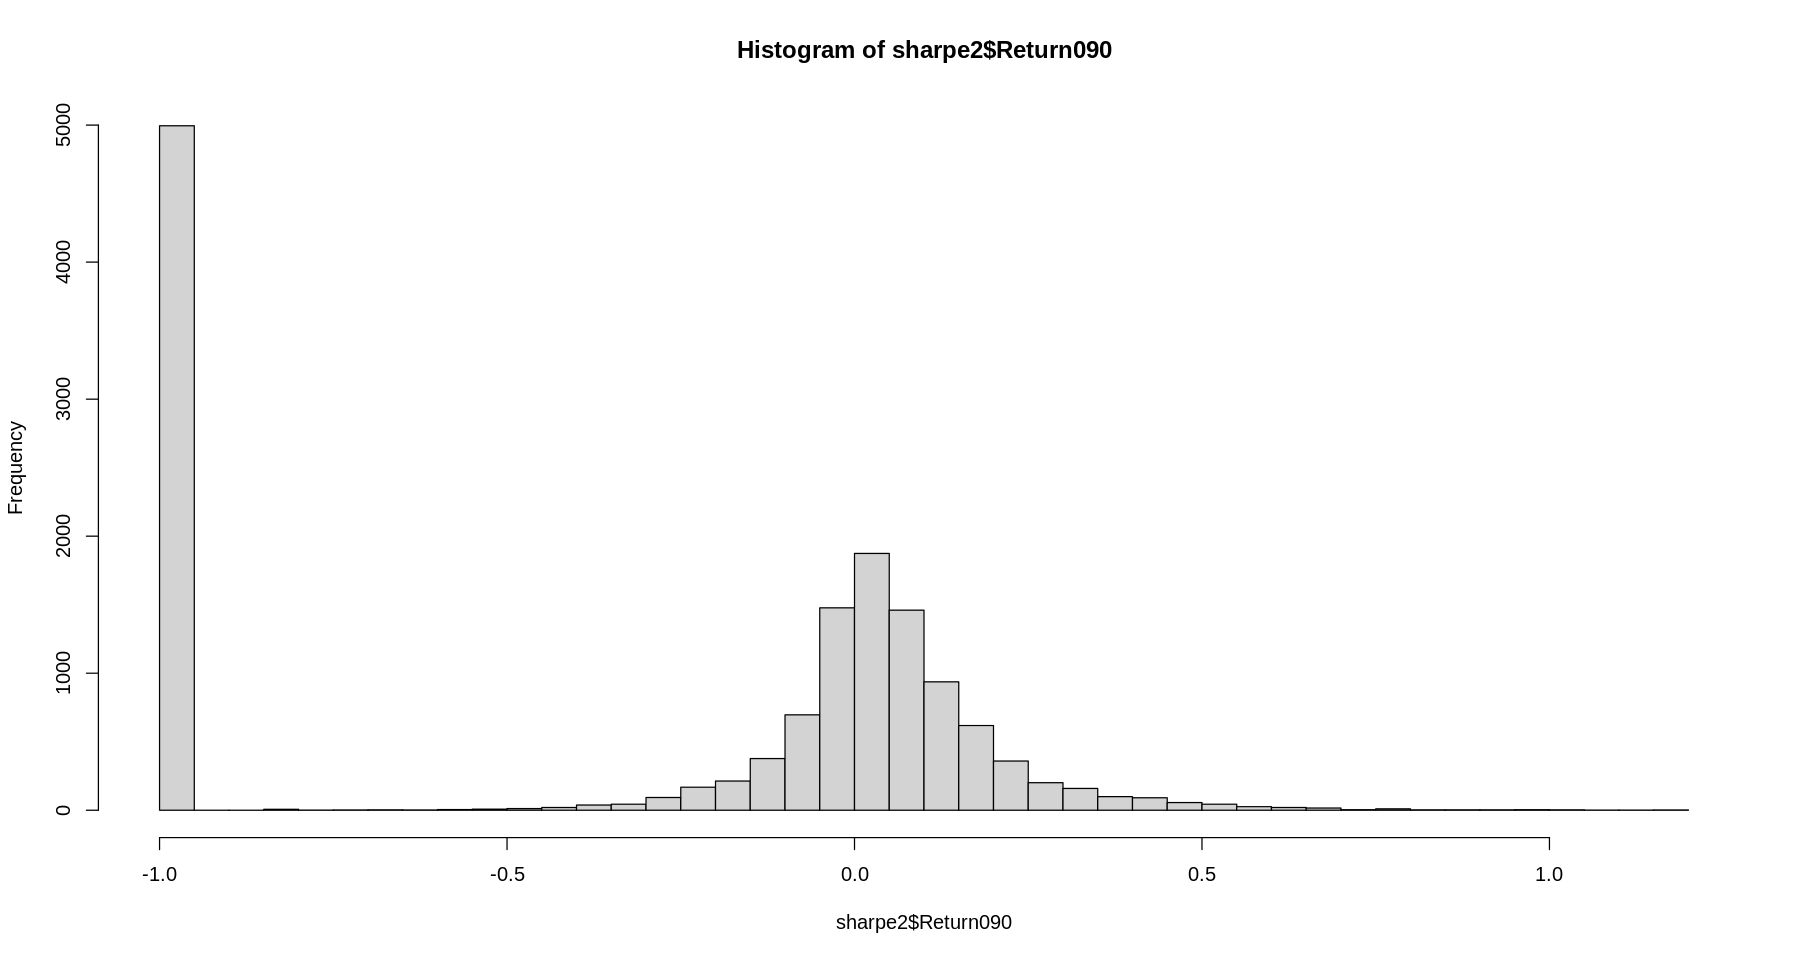

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.00000 -1.00000 -0.03196 -0.31985  0.06754  1.19031 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.00000 -1.00000 -1.00000 -0.49169  0.06559  1.66670 

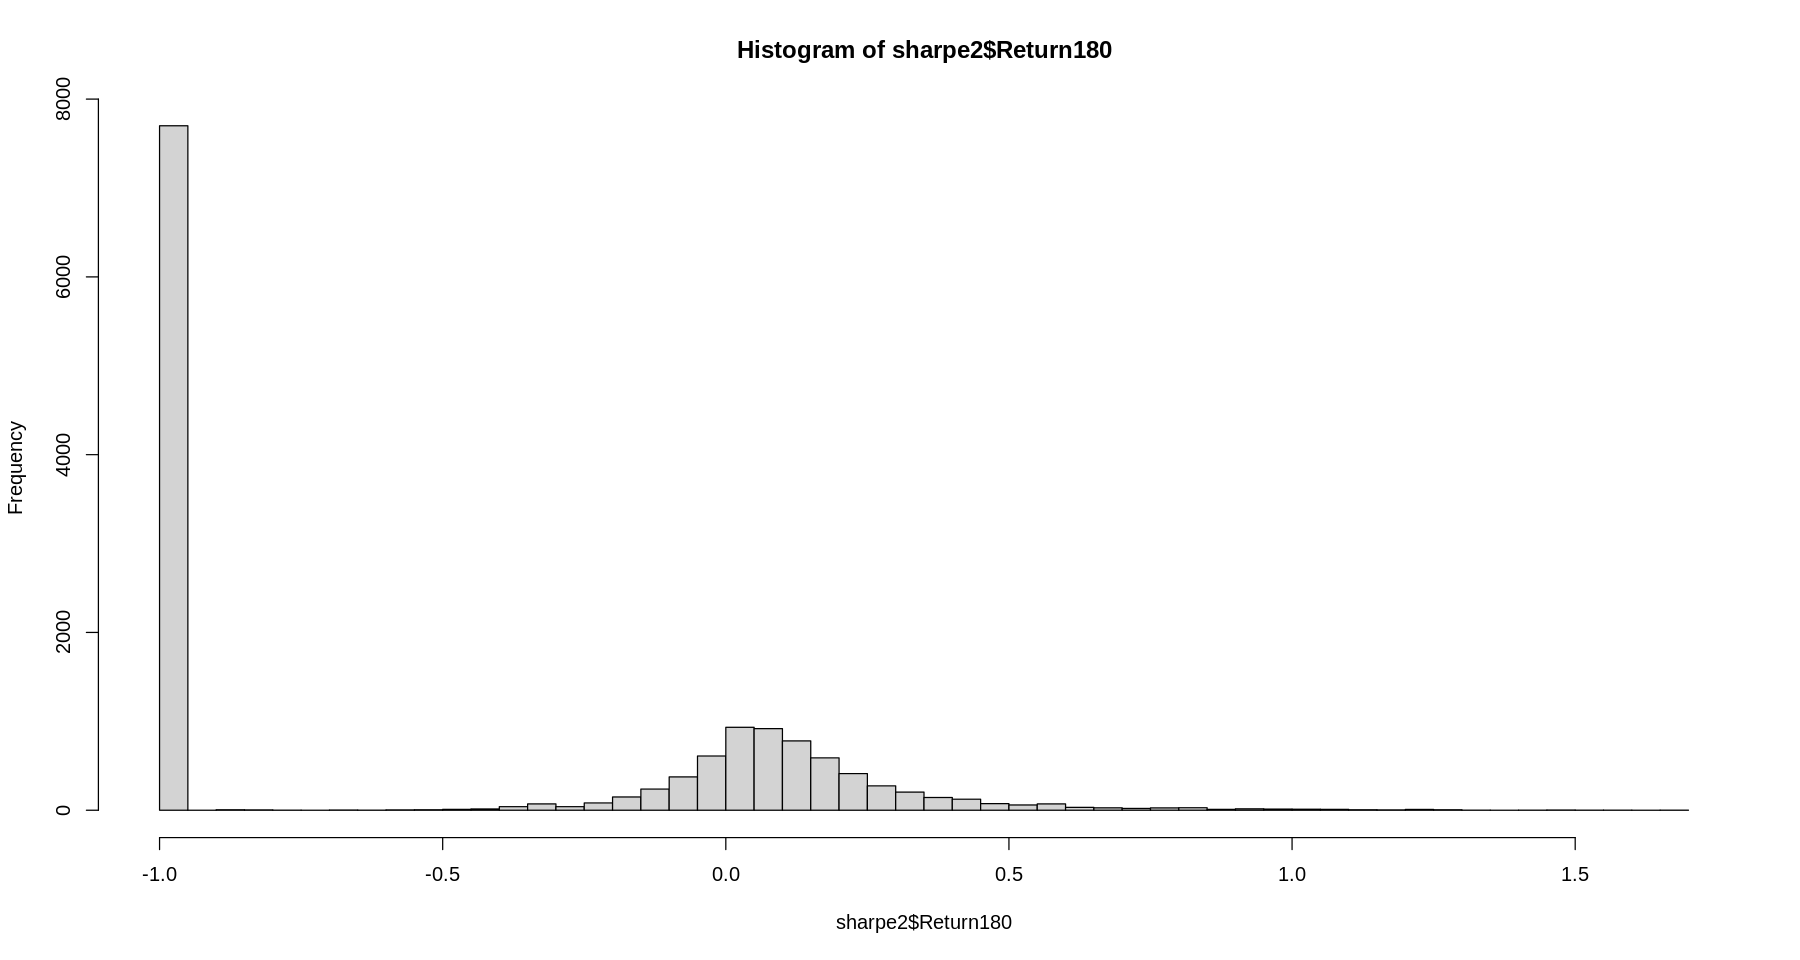

In [25]:
#sharpe2
hist(sharpe2$Return090,breaks=50)
hist(sharpe2$Return180,breaks=50)
summary(sharpe2$Return090)
summary(sharpe2$Return180)

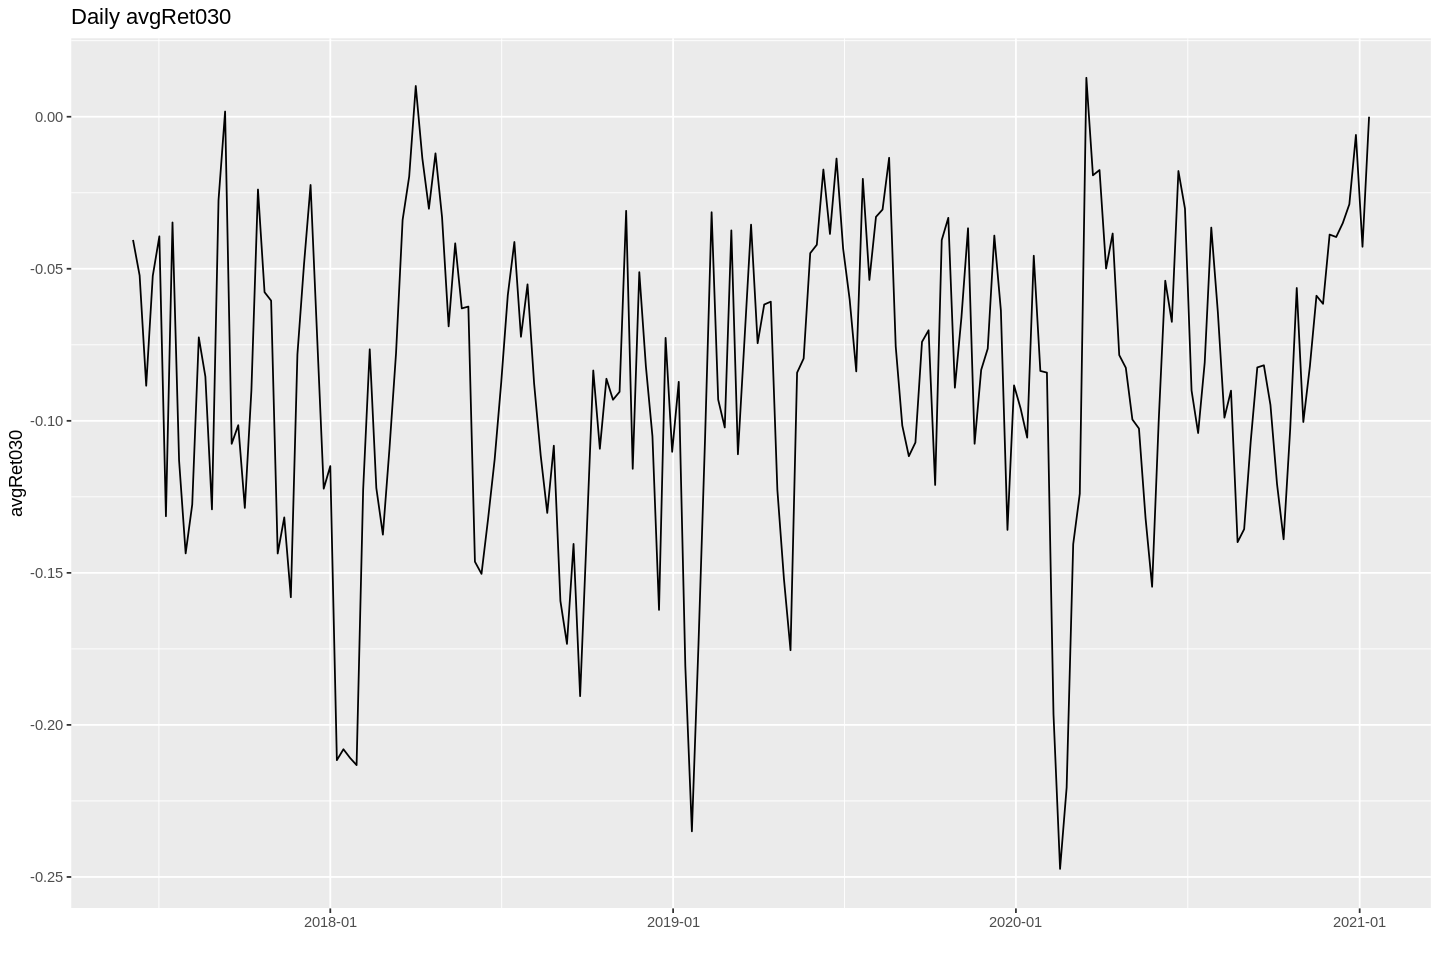

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.2473 -0.1130 -0.0833 -0.0864 -0.0449  0.0128 
Number of observations (days) = 189  SD =  0.05051 


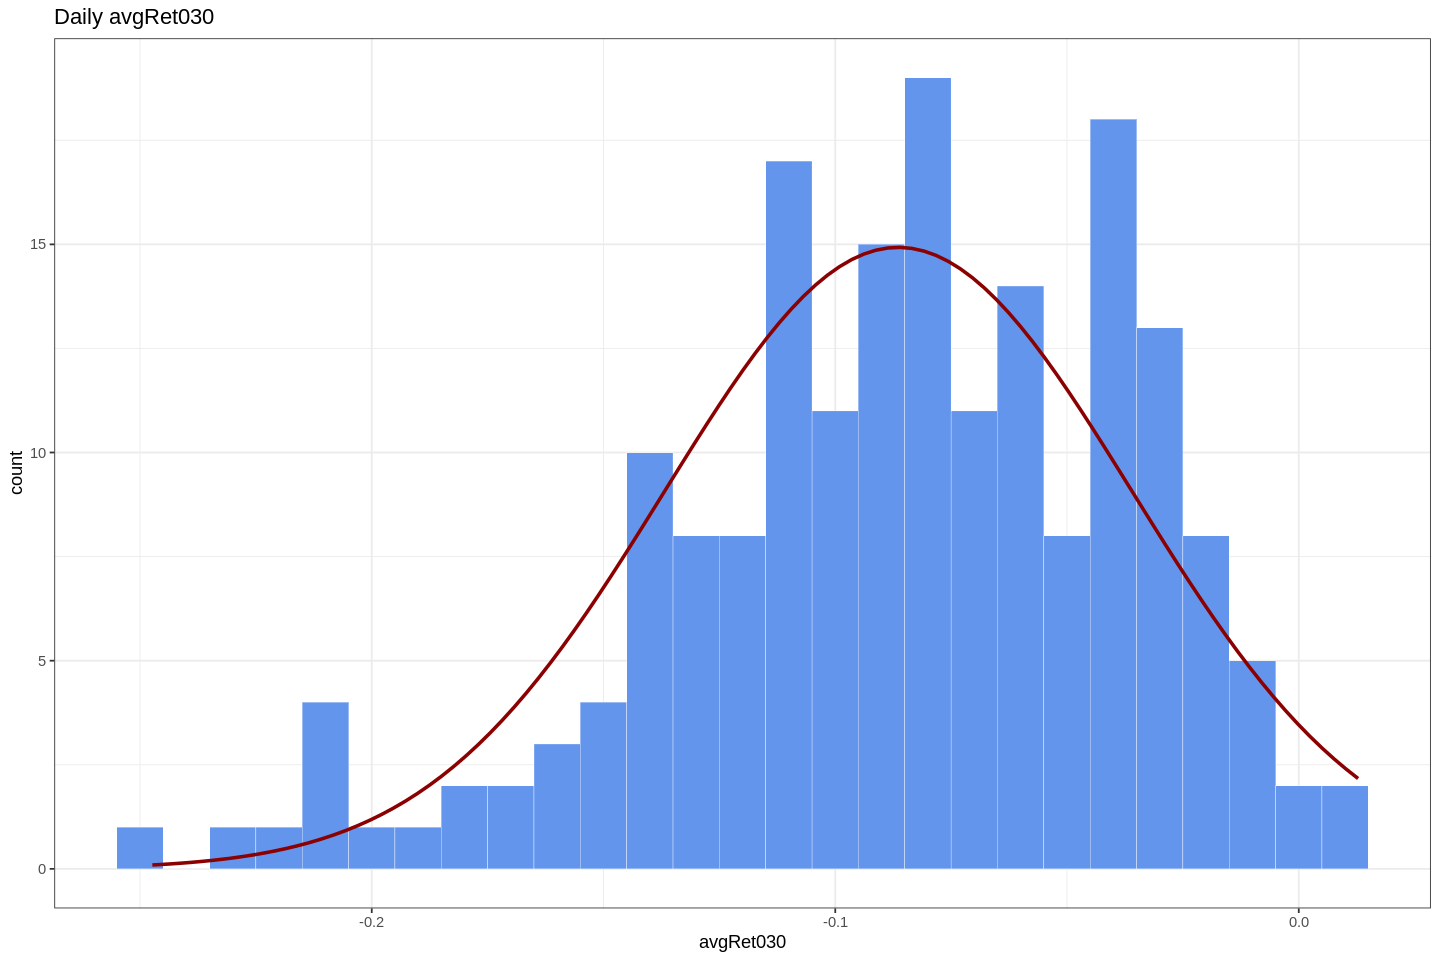

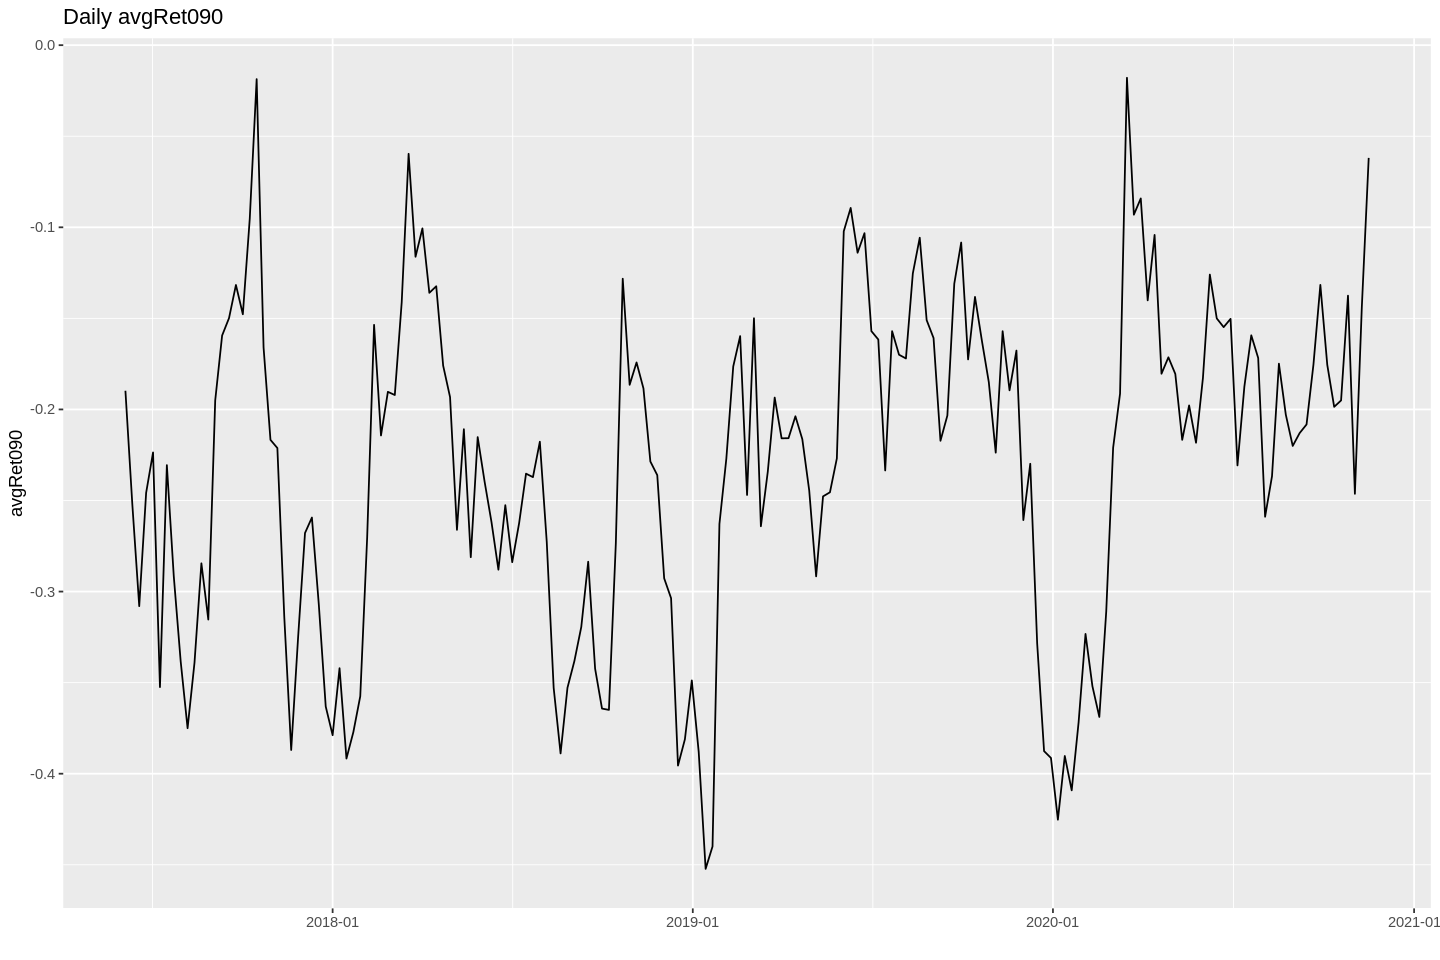

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.4523 -0.2880 -0.2172 -0.2297 -0.1623 -0.0179 
Number of observations (days) = 181  SD =  0.09 


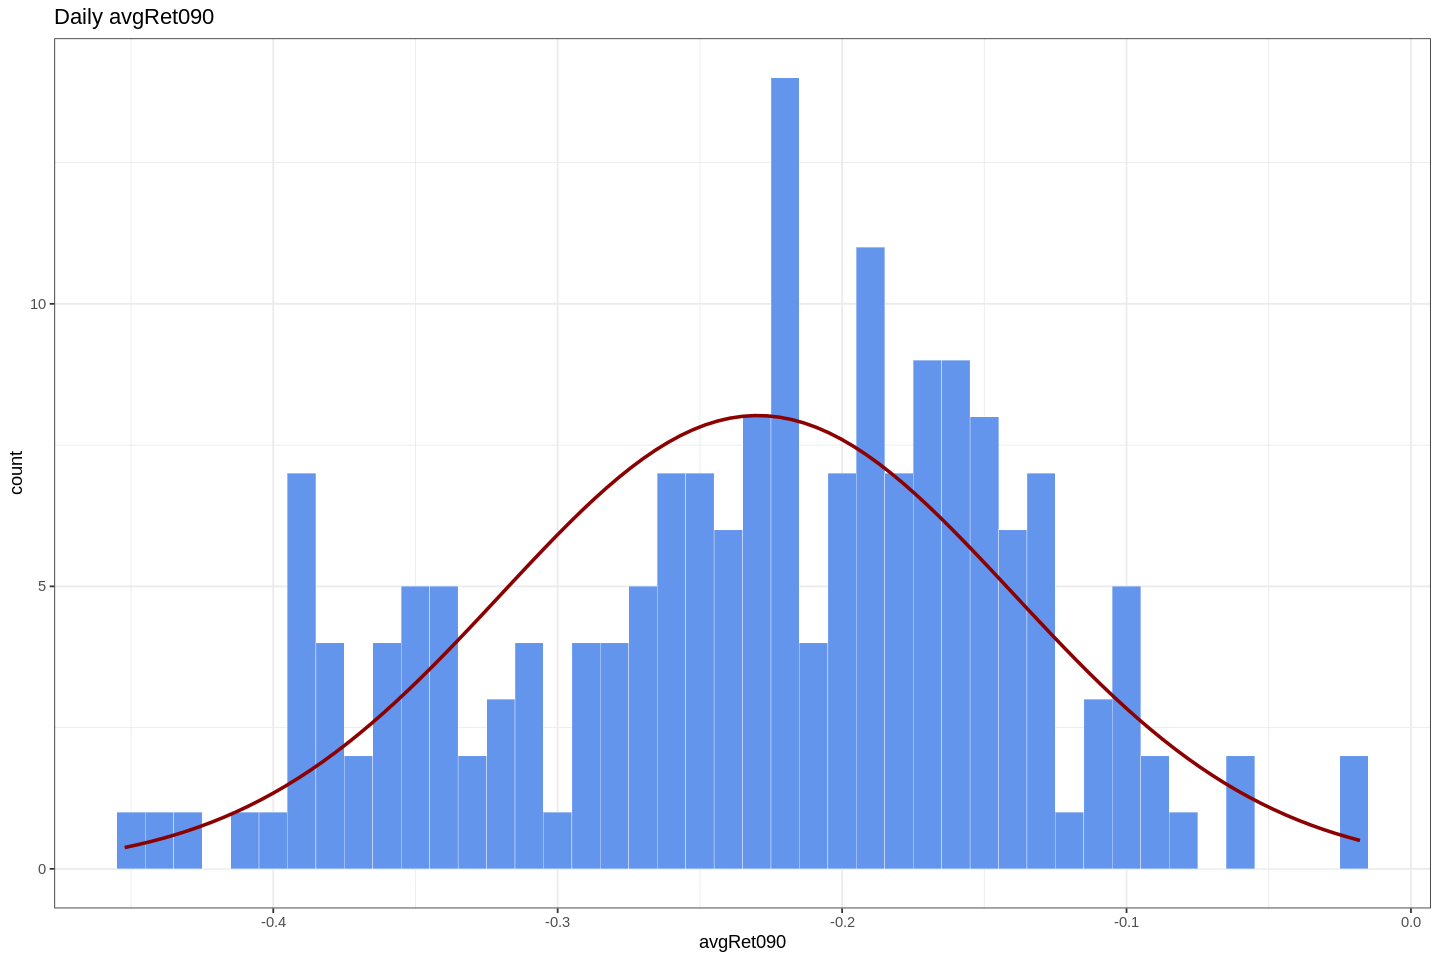

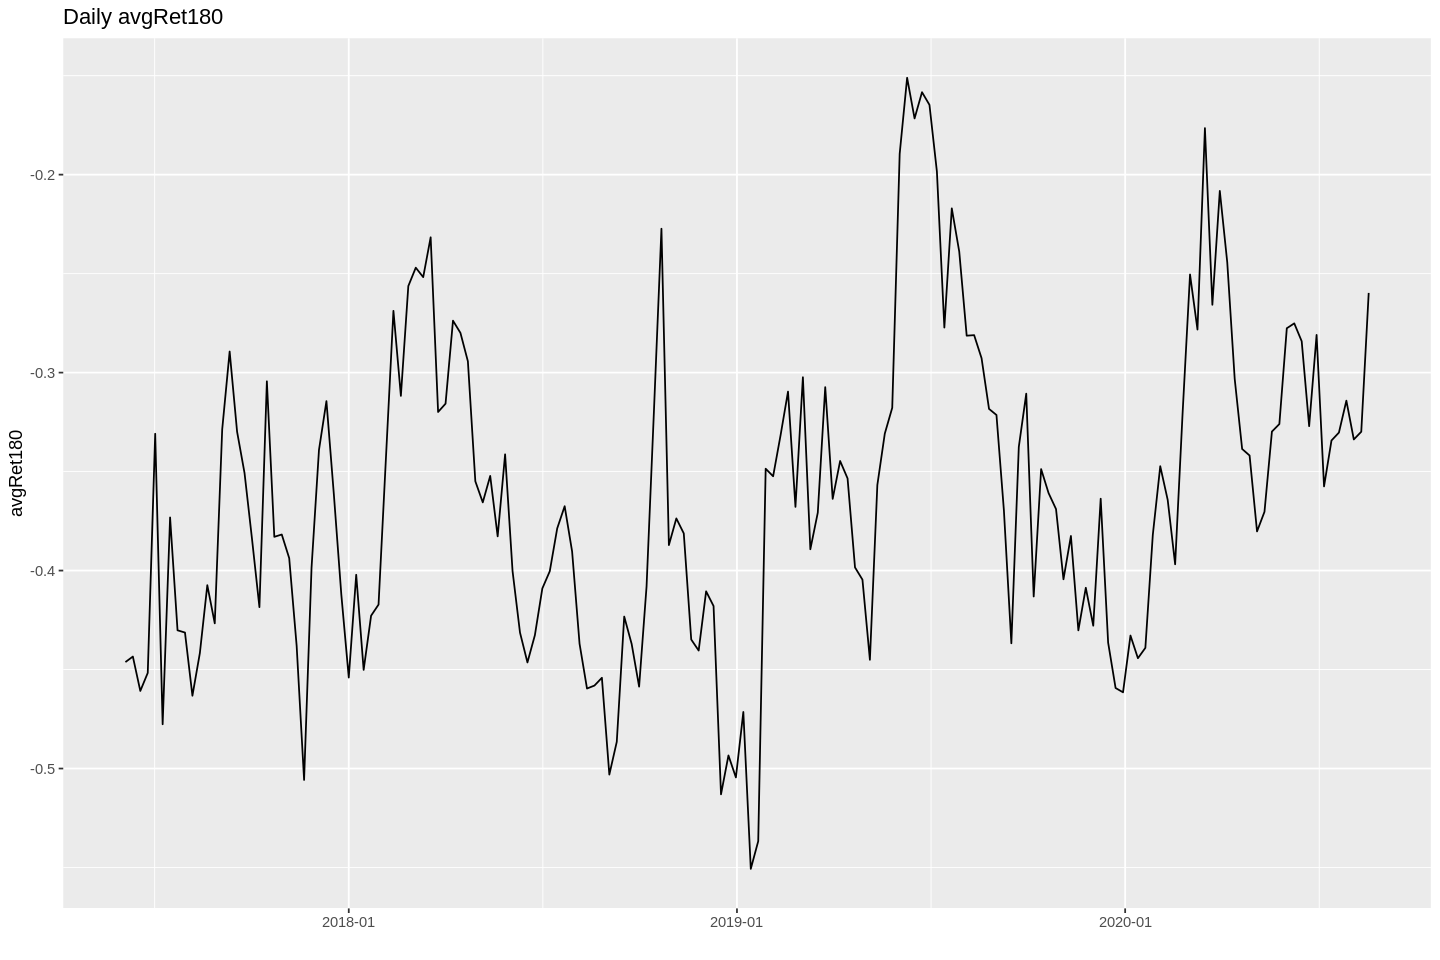

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.551  -0.427  -0.366  -0.363  -0.315  -0.151 
Number of observations (days) = 168  SD =  0.07972 


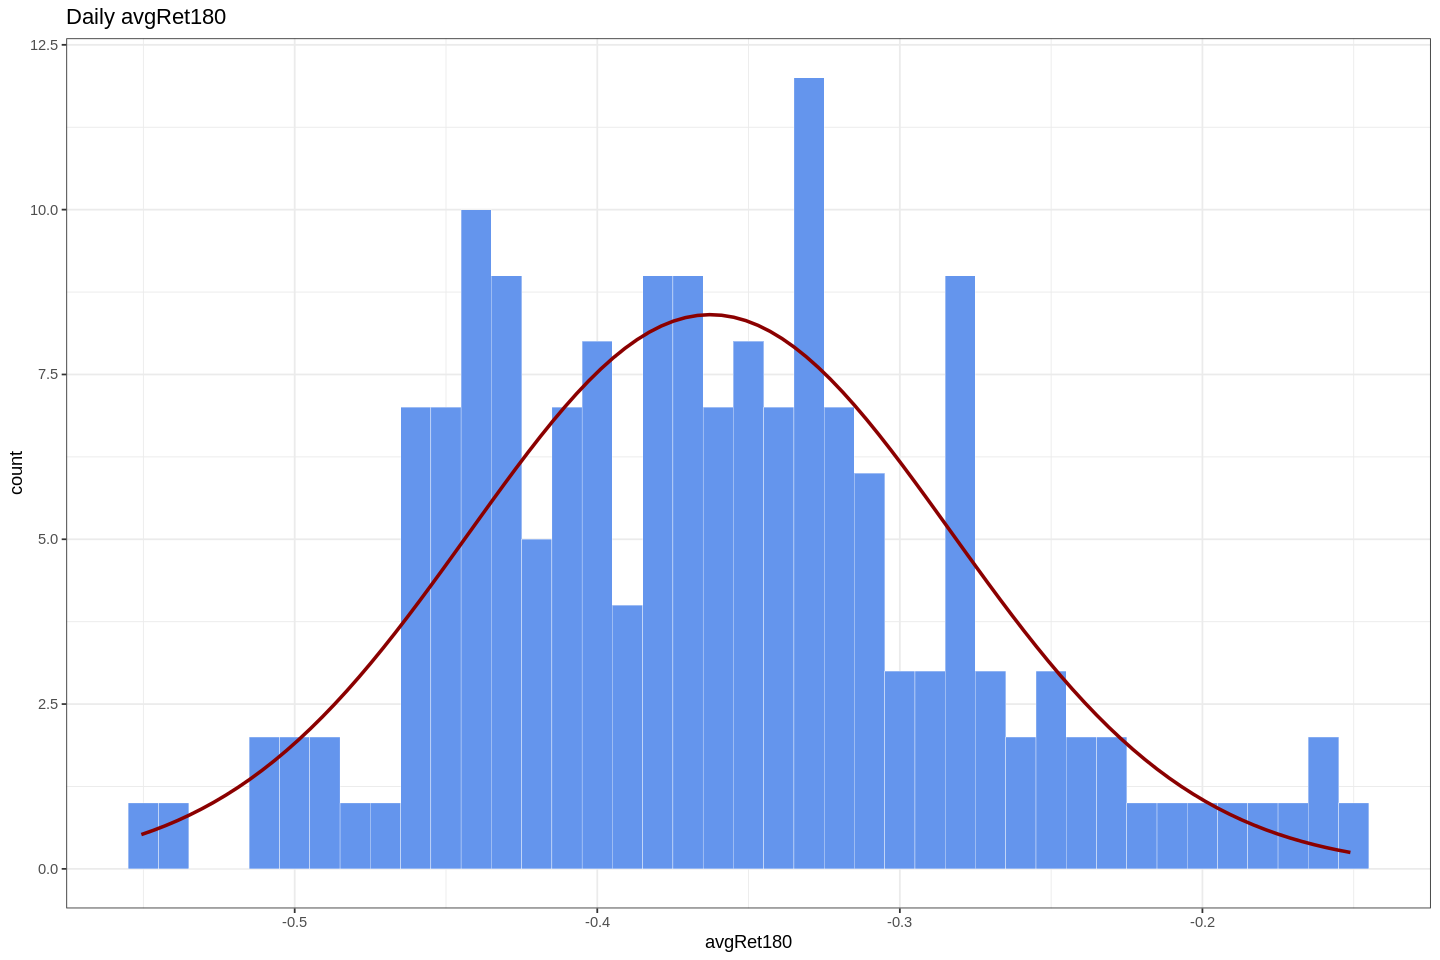

In [26]:
sql = "select DateStart, avg(Return030) as avgRet030, avg(Return090) as avgRet090, avg(Return180) as avgRet180 
 from ReturnsDataInIntervalsCleaned eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where statname='jSharpe'
 and Age > 30 # at least 30 for Sharpe making sense
 and statval > 2
 group by DateStart;"

sharpe22 = getC2ScoreDbData(sql)

populationDataDaily(sharpe22,030,"avgRet030")
populationDataDaily(sharpe22,090,"avgRet090")
populationDataDaily(sharpe22,180,"avgRet180")

In [27]:
# Hypothesis for returns when Sharpe < 0 
# ---------------------------------------
sql = "select statval, eq.*
from ReturnsDataInIntervalsCleaned eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where statname='jSharpe'
 and Age > 30 # at least 30 for Sharpe making sense
 and statval < 0 ;"

sharpe0 = getC2ScoreDbData(sql)

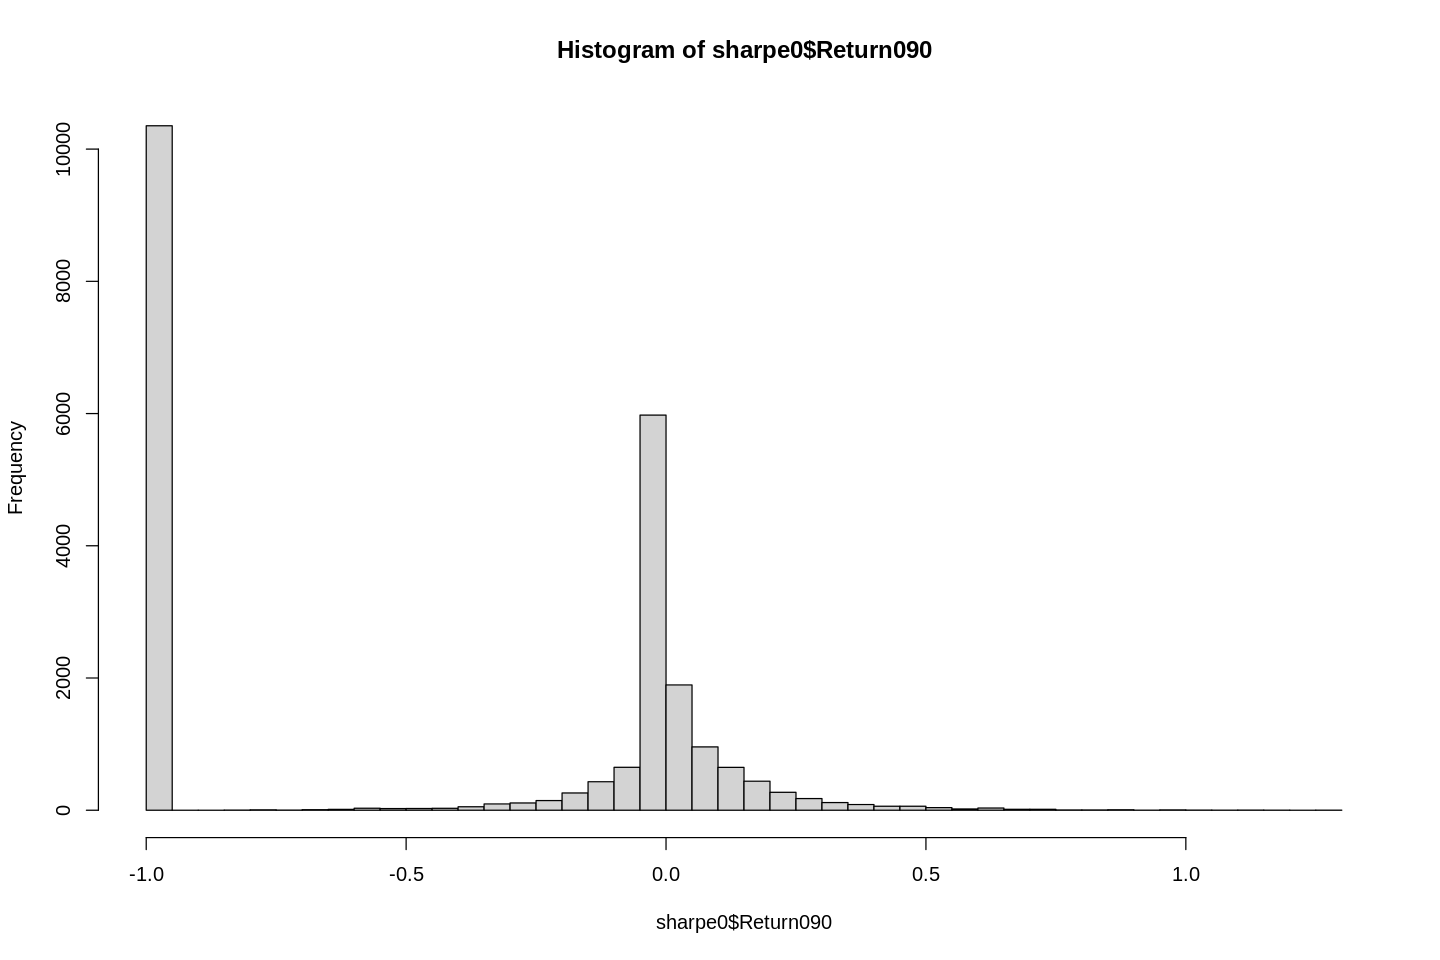

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -1.000  -1.000  -0.107  -0.439   0.000   1.262 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -1.000  -1.000  -1.000  -0.623   0.000   1.617 

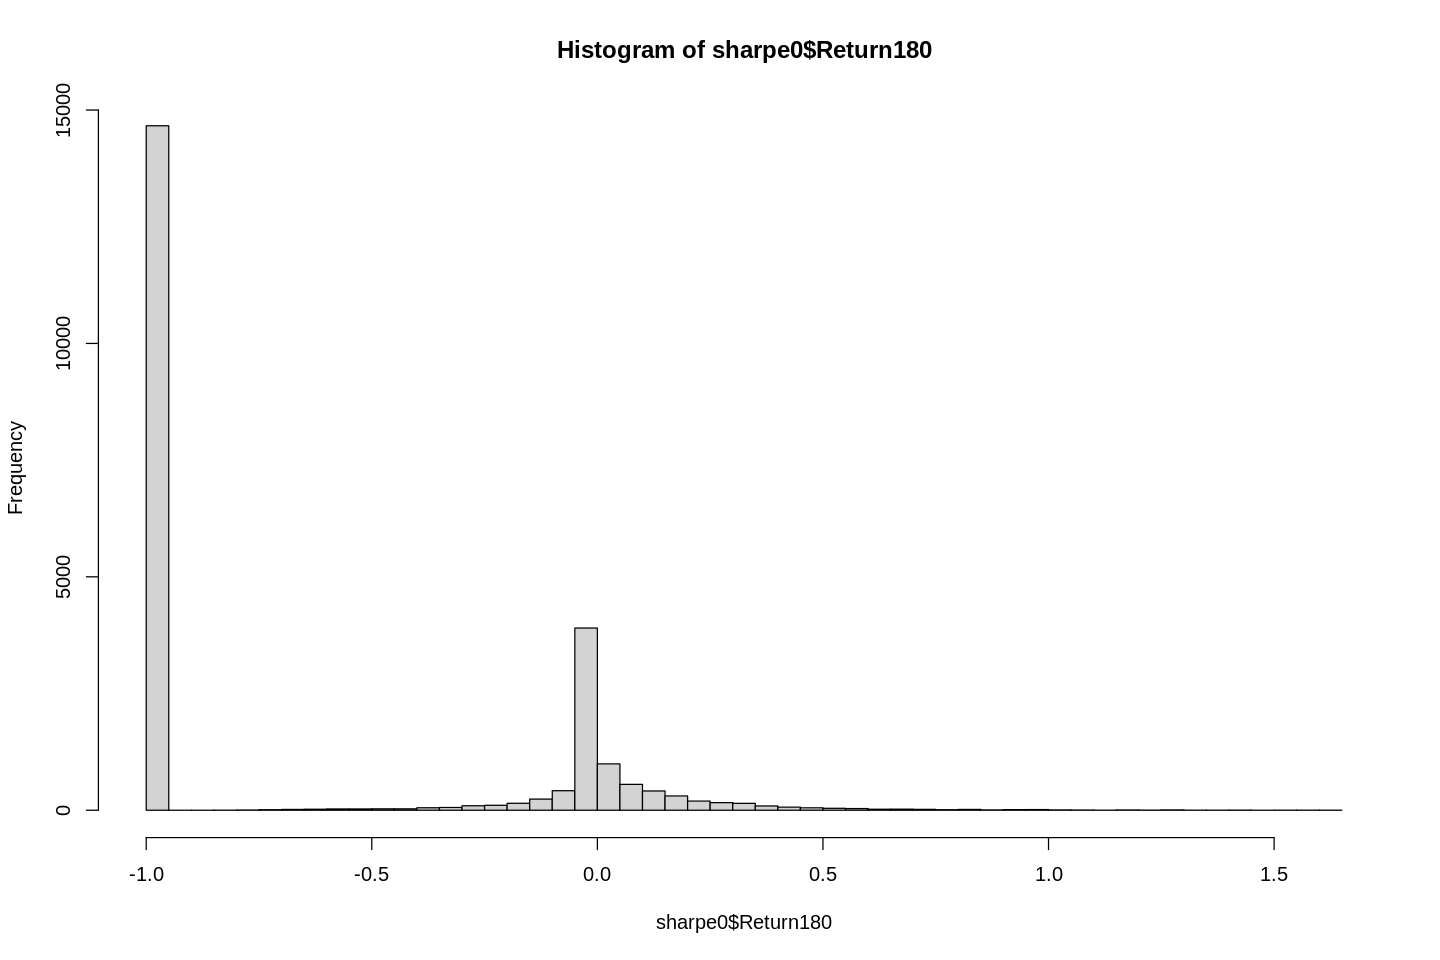

In [28]:
hist(sharpe0$Return090,breaks=50)
hist(sharpe0$Return180,breaks=50)
summary(sharpe0$Return090)
summary(sharpe0$Return180)

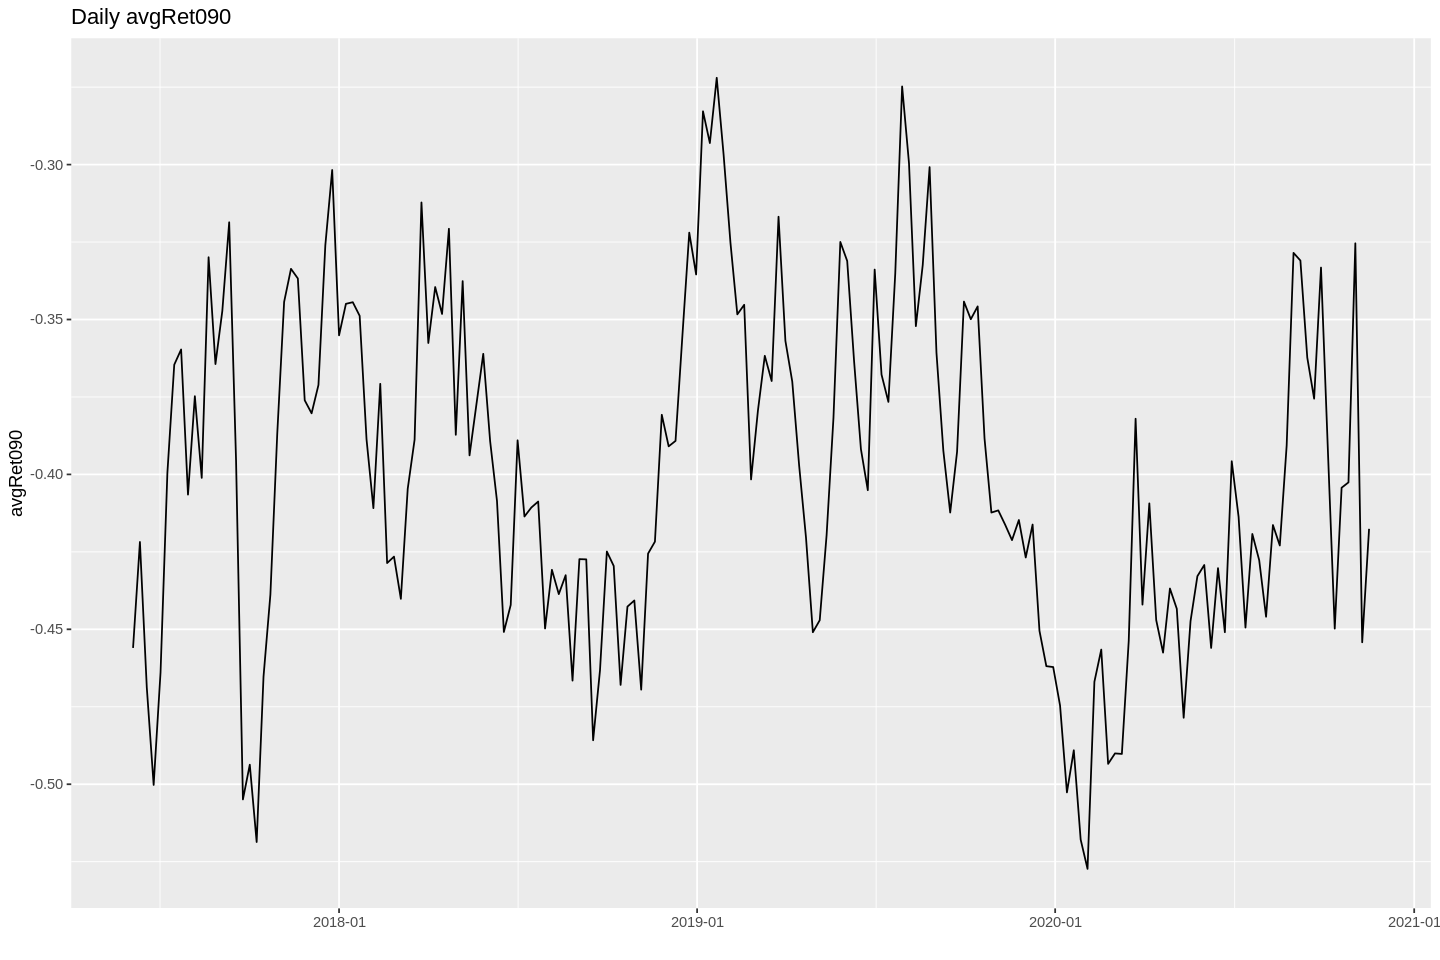

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.527  -0.441  -0.403  -0.400  -0.358  -0.272 
Number of observations (days) = 181  SD =  0.05433 


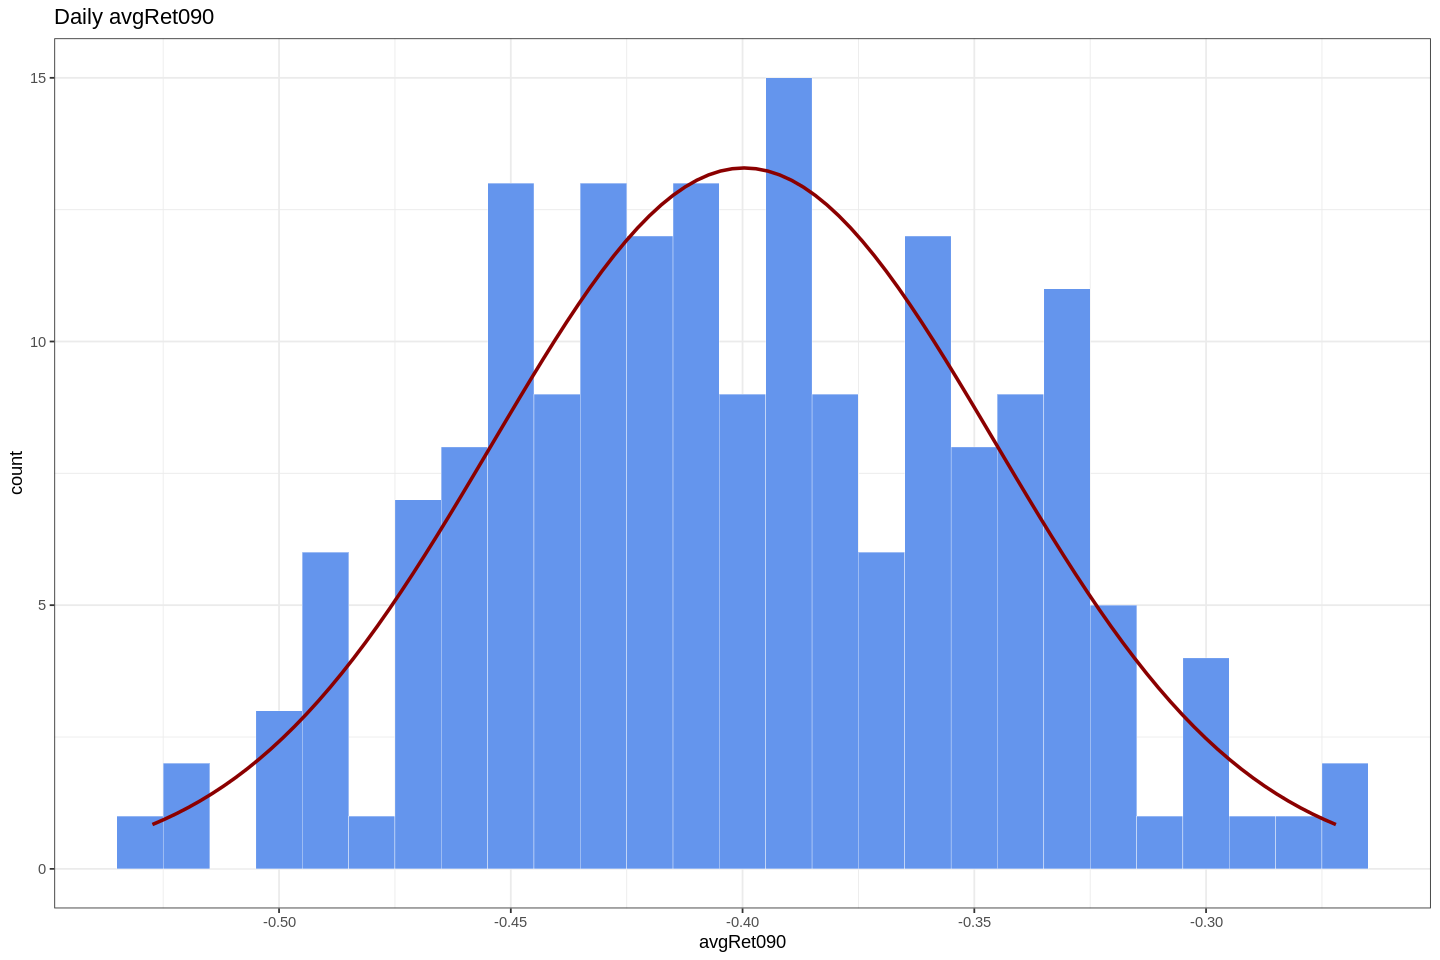

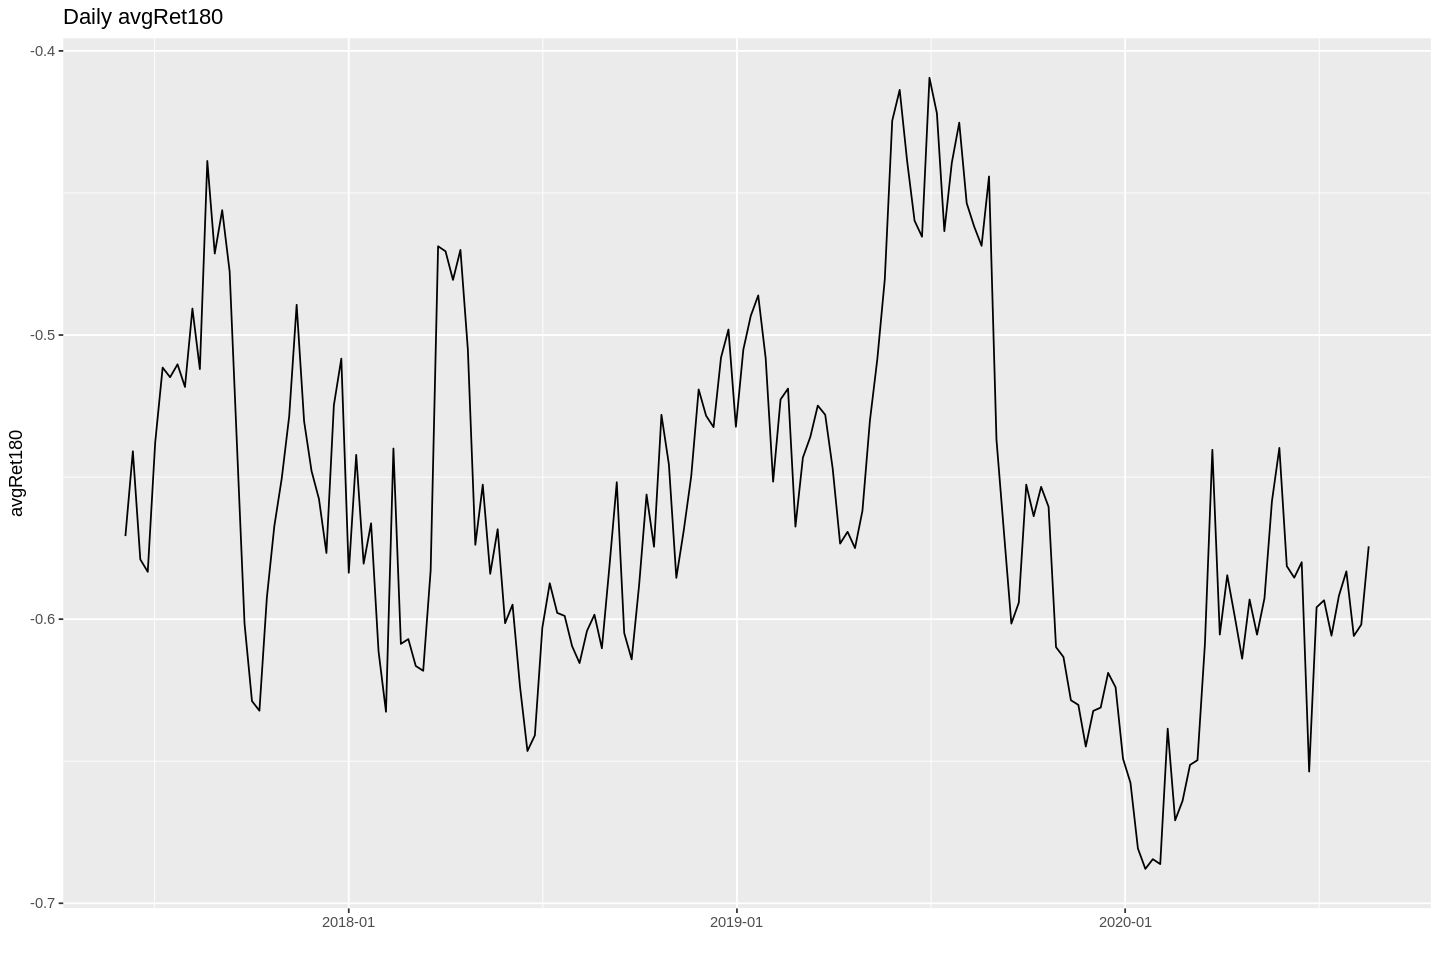

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.688  -0.605  -0.569  -0.561  -0.524  -0.409 
Number of observations (days) = 168  SD =  0.0615 


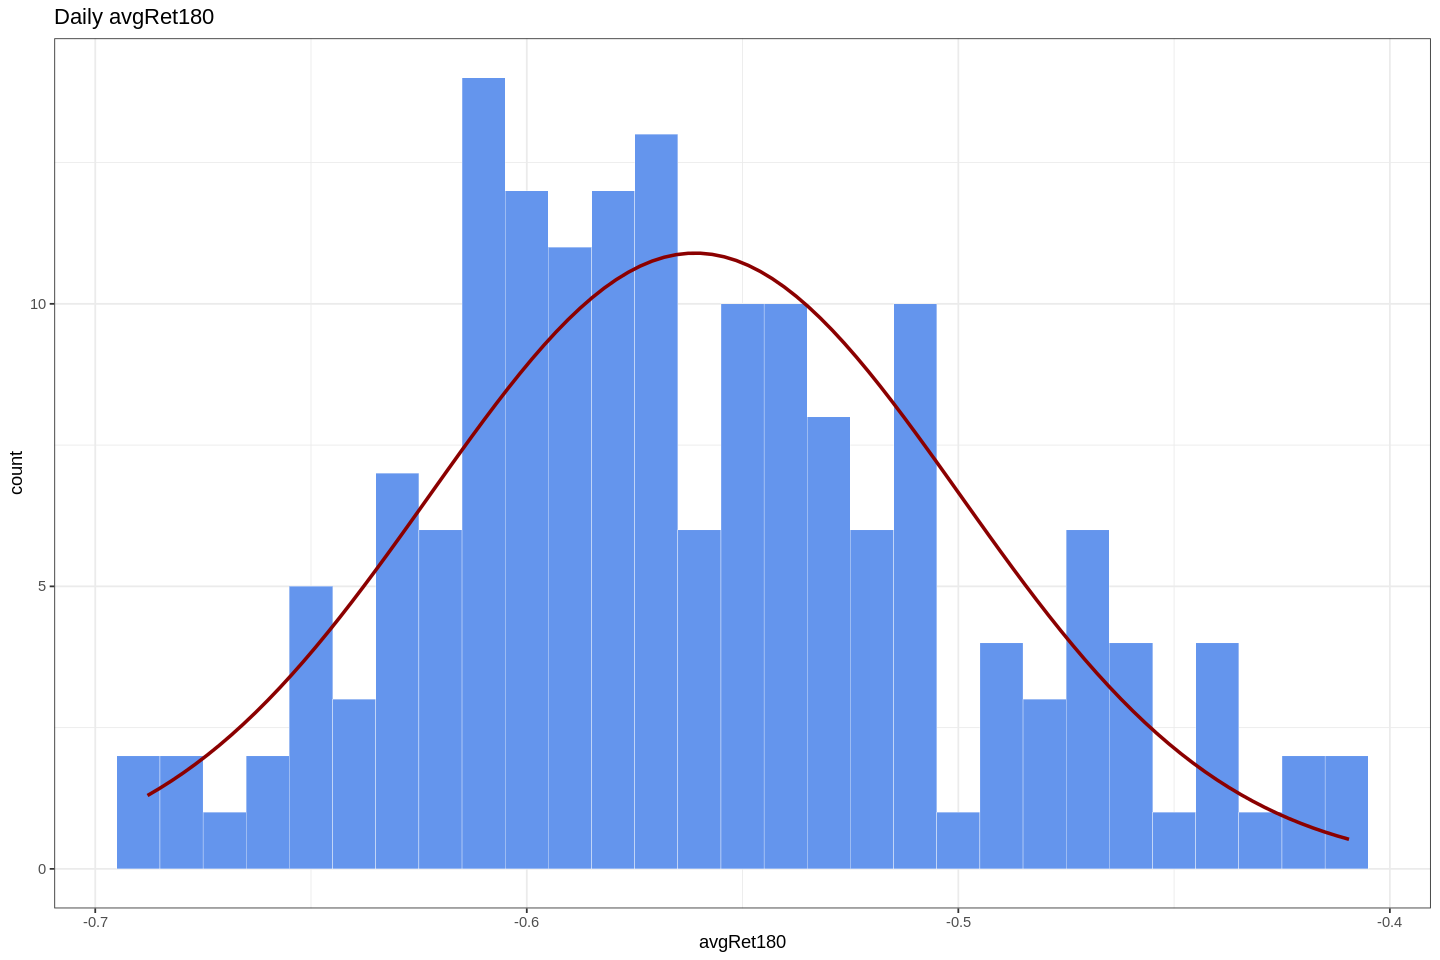

In [29]:
sql = "select DateStart, avg(Return090) as avgRet090, avg(Return180) as avgRet180
 from ReturnsDataInIntervalsCleaned eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where statname='jSharpe'
 and Age > 30 # at least 30 for Sharpe making sense
 and statval < 0 
 group by DateStart;"

sharpe02 = getC2ScoreDbData(sql)

populationDataDaily(sharpe02,090,"avgRet090")
populationDataDaily(sharpe02,180,"avgRet180")